In [1264]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.optimize import leastsq
import featuretools as ft

Note:加速度的单位是g(重力加速度),角速度单位是角度制

In [1265]:
raw_data=pd.read_csv('meta_data/Data2.csv')
label_1=pd.read_csv('meta_data/Label_of_Data1.csv')
raw_data_M=np.array(raw_data)
# i_s=(raw_data.iloc[:,-1]==1)    #raw_data中start/end action的连续index
# i_g=(raw_data.iloc[:,-2]==1)    #raw_data中过渡动作的连续index
# i_a=(label_1.iloc[:,0]>='0')    #手势动作的起点,终点index

# action_label=label_1[i_a].iloc[:,1:]
# action_label.reset_index()
# action_label.to_csv('Output-data/action_label.csv')
action_label=pd.read_csv('Output-data/action_label.csv')
action_label=np.array(action_label.iloc[:,1:])

# non_gesture_label=label_1[-i_a].iloc[:,1:]
# non_gesture_label.reset_index()
# non_gesture_label.iloc[43,1]=30014
# non_gesture_label.to_csv('Output-data/non_gesture_label.csv')
non_gesture_label=pd.read_csv('Output-data/non_gesture_label.csv')
non_gesture_label=np.array(non_gesture_label.iloc[:,1:])


# start_data=raw_data[i_s].iloc[:,:7].reset_index()
# transition_data=raw_data[i_g].iloc[:,:7].reset_index()
Time=raw_data_M[:,0]


In [1266]:
def filter1d(raw_data,T=125):
    data_p=np.zeros(raw_data.shape)
    
    for k in range(len(raw_data)):
        if k< (T-1)/2  :
            data_p[k]=np.mean(raw_data[k:int(k+(T-1)/2+1)])
        elif len(raw_data)-1-k<(T-1)/2:
            data_p[k]=np.mean(raw_data[int(k-(T-1)/2):k])

        else:
            data_p[k]=np.mean(raw_data[int(k-(T-1)/2):int(k+(T-1)/2+1)],0)
    return data_p

In [1267]:

#   先平滑数据,再计算
#   加大窗口
T=125     #   阈值法的窗口设为125,峰值法设为11
data_p=np.zeros(raw_data_M.shape)
data_p[:,0]=raw_data_M[:,0]
for k in range(len(raw_data_M[:,0])):
    if k< (T-1)/2 or len(raw_data_M[:,0])-1-k<(T-1)/2:
        data_p[k,1:]=raw_data_M[k,1:7]
    else:
        data_p[k,1:]=np.mean(raw_data_M[int(k-(T-1)/2):int(k+(T-1)/2+1),1:7],0)

E_acc=(data_p[:,1]**2 + data_p[:,2]**2 + data_p[:,3]**2)
E_omega=(data_p[:,4]**2 + data_p[:,5]**2 + data_p[:,6]**2)
#   进行归一化
def normalization(data):
    data=2*(data-data.min())/(data.max()-data.min())-1
    return data
E_acc=normalization(E_acc)
E_omega=normalization(E_omega)



In [1268]:
# sns.set()

# plt.plot(Time,raw_data_M[:,1])
# plt.plot(Time,data_p[:,1])
# plt.legend(('raw','filtered'))
# plt.xlim((0,50))
# plt.show()

In [1269]:
# sns.set()
# plt.plot(Time,E_acc)
# plt.xlim((0,50))
# plt.show()

In [1270]:

def gesture_figure(k,dpi=100):
    sns.set()
    plt.figure(dpi=dpi)
    
    plt.subplot(2,1,1)
    plt.plot(data_p[action_label[k,0]:action_label[k,1]+1,0],E_acc[action_label[k,0]:action_label[k,1]+1],color='r')
    plt.xlabel('time(s)')
    plt.ylabel('E_acc')
    plt.title('gesture action')
    plt.show()

    plt.figure(dpi=dpi)
    plt.subplot(2,1,2)
    plt.plot(data_p[action_label[k,0]:action_label[k,1]+1,0],E_omega[action_label[k,0]:action_label[k,1]+1],color='b')
    plt.xlabel('time(s)')
    plt.ylabel('E_omega')
    plt.title('gesture action')
    plt.show()




In [1271]:
def non_gesture_figure(non_gesture_label_2,k,dpi=100):
    sns.set()
    plt.figure(dpi=dpi)
    
    plt.subplot(2,1,1)
    plt.plot(Time[non_gesture_label_2[k,0]:non_gesture_label_2[k,1]+1],E_acc[non_gesture_label_2[k,0]:non_gesture_label_2[k,1]+1],color='r')
    plt.xlabel('time(s)')
    plt.ylabel('E_acc')
    plt.title('non gesture action')
    plt.show()

    plt.figure(dpi=dpi)
    plt.subplot(2,1,2)
    plt.plot(Time[non_gesture_label_2[k,0]:non_gesture_label_2[k,1]+1],E_omega[non_gesture_label_2[k,0]:non_gesture_label_2[k,1]+1],color='b')
    plt.xlabel('time(s)')
    plt.ylabel('E_omega')
    plt.title('non gesture action')
    plt.show()

In [1272]:
#   用ltx的方法尝试一下
flip=filter1d(E_acc,T=5000)*1.4
g_point=np.array(np.where(E_acc>flip)).flatten()
t_point=np.array(np.where(E_acc<=flip)).flatten()
g_point2=pd.Series(g_point)
g_point2.to_csv('g_point2.csv')
t_point2=pd.Series(t_point)
t_point2.to_csv('t_point2.csv')

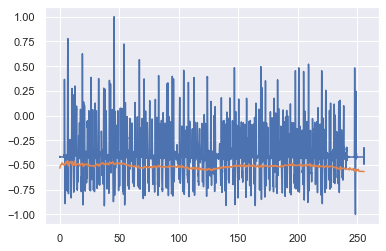

In [1273]:
sns.set()
plt.plot(Time,E_acc)
plt.plot(Time,flip)

plt.show()

In [1274]:
g_point1=pd.read_csv('g_point1.csv')
t_point1=pd.read_csv('t_point1.csv')
g_point1=np.array(g_point1.iloc[:,1])
t_point1=np.array(t_point1.iloc[:,1])


In [1275]:
g_point_final=np.union1d(g_point1,g_point2)
t_point_final=np.setdiff1d(np.arange(len(E_acc)),g_point_final)
startpoint_g=list([g_point_final[0]])
endpoint_g=list()
#   进行分割
for k in range(1,len(g_point_final)-1):
    if g_point_final[k]-g_point_final[k-1]>1:
        startpoint_g.append(g_point_final[k])
        endpoint_g.append(g_point_final[k-1])
endpoint_g.append(g_point_final[-1])
endpoint_g=np.array(endpoint_g)
startpoint_g=np.array(startpoint_g)
action_label_2=np.stack((startpoint_g,endpoint_g),1)


In [1276]:

# for k in range(0,50000,5000):
#     sns.set()
#     plt.figure(dpi=500)
#     plt.scatter(action_label_3[:,0],action_label_3[:,1])
#     plt.scatter(action_label[:,0],action_label[:,1])
#     plt.scatter(non_gesture_label[:,0],non_gesture_label[:,1])
#     plt.legend(('predictted-ges','real-ges','real-non-ges'))
#     plt.xlim((k,k+5000))
#     plt.savefig('%d.png'%k)
    

In [1277]:
#   删除错误片段

distance=115    #控制区间长度
distance2=250   #控制距离
action_label_3=np.delete(action_label_2,np.where((action_label_2[:,1]-action_label_2[:,0])<distance),0)
errorlist=[]
for k in range(len(action_label_3)-1):
    if (action_label_3[k,0]-action_label_3[k-1,1])<distance2 or (action_label_3[k+1,0]-action_label_3[k,1]<distance2):
        errorlist.append(k)
errorlist=np.array(errorlist)
#   在除去过渡区间的同时,也把与它相邻的区间除去了
#   通过观察可以发现,与手势区间相比,过渡区间与左右区间的距离里更小
#   因此可以用这个方法来判断出两个彼此相邻的区间中真正的过渡区间
errorlist2=[]
for k in range(len(errorlist)-1):
    if errorlist[k+1]-errorlist[k]==1:
        a=errorlist[k]
        b=errorlist[k+1]
        #   比较距离,删去errorlist中距离大的那个数值
        dis_a=(action_label_3[a,0]-action_label_3[a-1,1]) + (action_label_3[a+1,0]-action_label_3[a,1])
        dis_b=(action_label_3[b,0]-action_label_3[b-1,1]) + (action_label_3[b+1,0]-action_label_3[b,1])
        if dis_a < dis_b:
            errorlist2.append(k+1)
        else:
            errorlist2.append(k)


errorlist=np.delete(errorlist,errorlist2)
action_label_4=np.delete(action_label_3,errorlist,0)

peak=pd.read_csv('Output-data/peak(data1).csv').iloc[:,1].to_numpy()


pd.DataFrame(action_label_4,columns=['start','end']).to_csv('Output-data/gesture_label_predict(data2).csv')


如此得出最终结果,注意:第一个和最后一个为起始,终止动作


In [1278]:

# for k in range(0,50000,5000):
#     sns.set()
#     plt.figure(dpi=500)
#     plt.scatter(action_label_3[:,0],action_label_3[:,1])
#     plt.scatter(action_label_4[:,0],action_label_4[:,1])
#     plt.scatter(non_gesture_label[:,0],non_gesture_label[:,1])
#     plt.legend(('ver3-ges','ver4-ges','real-non-ges'))
#     plt.xlim((k,k+5000))
#     plt.savefig('%dver4.png'%k)

In [1279]:
#   接下来确定过渡区间
#   首先获得原始区间数据
transition_label=[]
for k in range(1,len(action_label_4)-1):
    transition_label.append([action_label_4[k,1]+1,action_label_4[k+1,0]-1])
    
transition_label=np.array(transition_label)


In [1280]:
#   对每个区间进行精确定位
#   经过分析,平滑和归一化后的绝大多数过渡区间具有如下特点:
#   1)  合加速度曲线呈下降趋势
#   2)  合角速度先递增,再递减,具有单峰
#   绝大多数区间至少满足其中一个特征

In [1281]:
# for k in range(len(transition_label)):
#     non_gesture_figure(transition_label,k)

In [1282]:
#   求导,根据斜率判断

slope_a=np.gradient(E_acc,0.01)
slope_omega=np.gradient(E_omega,0.01)
s_o=filter1d(slope_omega,T=99)
s_a=filter1d(slope_a,99)
#   求二阶导
slope_a2=np.gradient(slope_a,0.1)
slope_o2=np.gradient(s_o,0.01)


In [1283]:
def func(p,x):
    k,b=p
    return k*x+b

def costfunc(p,x,y):
    return func(p,x)-y

In [1284]:

p0=[1,0]    
predict_interval=np.array([0])
for k in range(len(transition_label)):
    begin=transition_label[k,0]
    end=transition_label[k,1]
    W=50
    n=int((end-begin)/W)+1
    list_slope_o=[]
    list_slope_a=[]

    X=np.zeros((n,W),dtype=int)
    cnt=end+1-(begin+(n-1)*W)
    for i in range(n):
        X[i]=np.arange(begin+i*W,begin+(i+1)*W)
    
    for i in range(n):
        #   拟合直线
        para_o=leastsq(costfunc,p0,args=(X[i],E_omega[X[i]]))
        para_a=leastsq(costfunc,p0,args=(X[i],E_acc[X[i]]))
        list_slope_o.append(para_o[0][0])
        list_slope_a.append(para_a[0][0])
    if n<=3:
        for i in range(n-1):
            predict_interval=np.append(predict_interval,X[i])
        predict_interval=np.append(predict_interval,X[n-1][:cnt])
    else:
        list_a=np.array(list_slope_a)
        i=list_a.argmax()
        if n-i<=3:
            for t in range(i,n):
                predict_interval=np.append(predict_interval,X[t])
            predict_interval=np.append(predict_interval,X[n-1][:cnt])
        else:
            for t in range(i,i+3):
                predict_interval=np.append(predict_interval,X[t])


        # #   这一步判断表现很好,选出了最符合特征的10多段
        # if ((s_o[X[i]]>0).astype('int').sum()>0.8*W) and ((slope_omega[X[i+1]]<0).astype('int').sum()>0.8*W):
        #     predict_interval=np.append(predict_interval,X[i])
        #     predict_interval =np.append(predict_interval,X[i+1])
        
        # #   接下来用slope_a来判断
        # if (s_a[X[i]]<0).astype('int').sum()>0.7*W and (s_a[X[i+1]]<0).astype('int').sum()>0.7*W:
        #     predict_interval=np.append(predict_interval,X[i])
        #     predict_interval =np.append(predict_interval,X[i+1])

        # if ((np.abs(slope_omega[X[i]])<1e-2).astype('int').sum()>W/1.5) and cnt==0:
        #     cnt=1
        #     if (slope_omega[X[i+1]]>0).astype('int').sum()>W/1.5:
        #         predict_interval=np.append(predict_interval,X[i+1])



predict_interval=np.unique(predict_interval)
predict_interval=np.delete(predict_interval,0)


In [1285]:
#分割区间
startpoint_t=list([predict_interval[0]])
endpoint_t=[]
for k in range(1,len(predict_interval)-1):
    if predict_interval[k]-predict_interval[k-1]>1:
        startpoint_t.append(predict_interval[k])
        endpoint_t.append(predict_interval[k-1])
endpoint_t.append(predict_interval[-1])
startpoint_t
startpoint_t=np.array(startpoint_t)
endpoint_t=np.array(endpoint_t)
non_gesture_label_2=np.stack((startpoint_t,endpoint_t),axis=1)
non_gesture_label_3=non_gesture_label_2
#   过滤距离特别近的
# deletelist=[]
# for k in range(len(non_gesture_label_2)-1):
#     if non_gesture_label_2[k+1,0]-non_gesture_label_2[k,1]<250 :
#         deletelist.append(k)
# non_gesture_label_3=np.delete(non_gesture_label_2,deletelist,axis=0)

In [1286]:
output_label=np.append(action_label_4,non_gesture_label_3,axis=0)
output_label=np.sort(output_label,axis=0)
output_label=pd.DataFrame(output_label,columns=['start','end'])
output_label.to_csv('Output-data/output_label(Data2).csv')  #记得改文件名

In [1287]:
# for j in range(63):
#     X0=np.arange(non_gesture_label[j+1,0],non_gesture_label[j+1,1]+1)
#     Y0=E_omega[X0]
#     Y00=E_acc[X0]

#     X1=np.arange(transition_label[j,0],transition_label[j,1]+1)
#     Y1=E_omega[X1]
#     Y11=E_acc[X1]

#     # X2=np.arange(non_gesture_label_2[j,0],non_gesture_label_2[j,1])
#     # Y2=E_omega[X2]

#     sns.set()
#     plt.plot(X1,Y1)
#     plt.plot(X0,Y0)
#     # plt.plot(X2,Y2)
#     plt.plot(X1,s_o[X1])
#     plt.plot(X0,s_o[X0])
#     plt.plot(X1,slope_o2[X1])
#     #plt.legend(('whole','real','slope'))
#     plt.title('%d omega'%j)
#     plt.show()


In [1288]:
# for j in range(63):
#     X0=np.arange(non_gesture_label[j+1,0],non_gesture_label[j+1,1]+1)
#     Y0=E_omega[X0]
#     Y00=E_acc[X0]
#     X1=np.arange(transition_label[j,0],transition_label[j,1]+1)
#     Y1=E_omega[X1]
#     Y11=E_acc[X1]
#     sns.set()
#     plt.plot(X1,Y11)
#     plt.plot(X0,Y00)
#     plt.plot(X1,s_a[X1])
#     plt.plot(X0,s_a[X0])
#     plt.title('%d acc'%j)
#     plt.show()
    

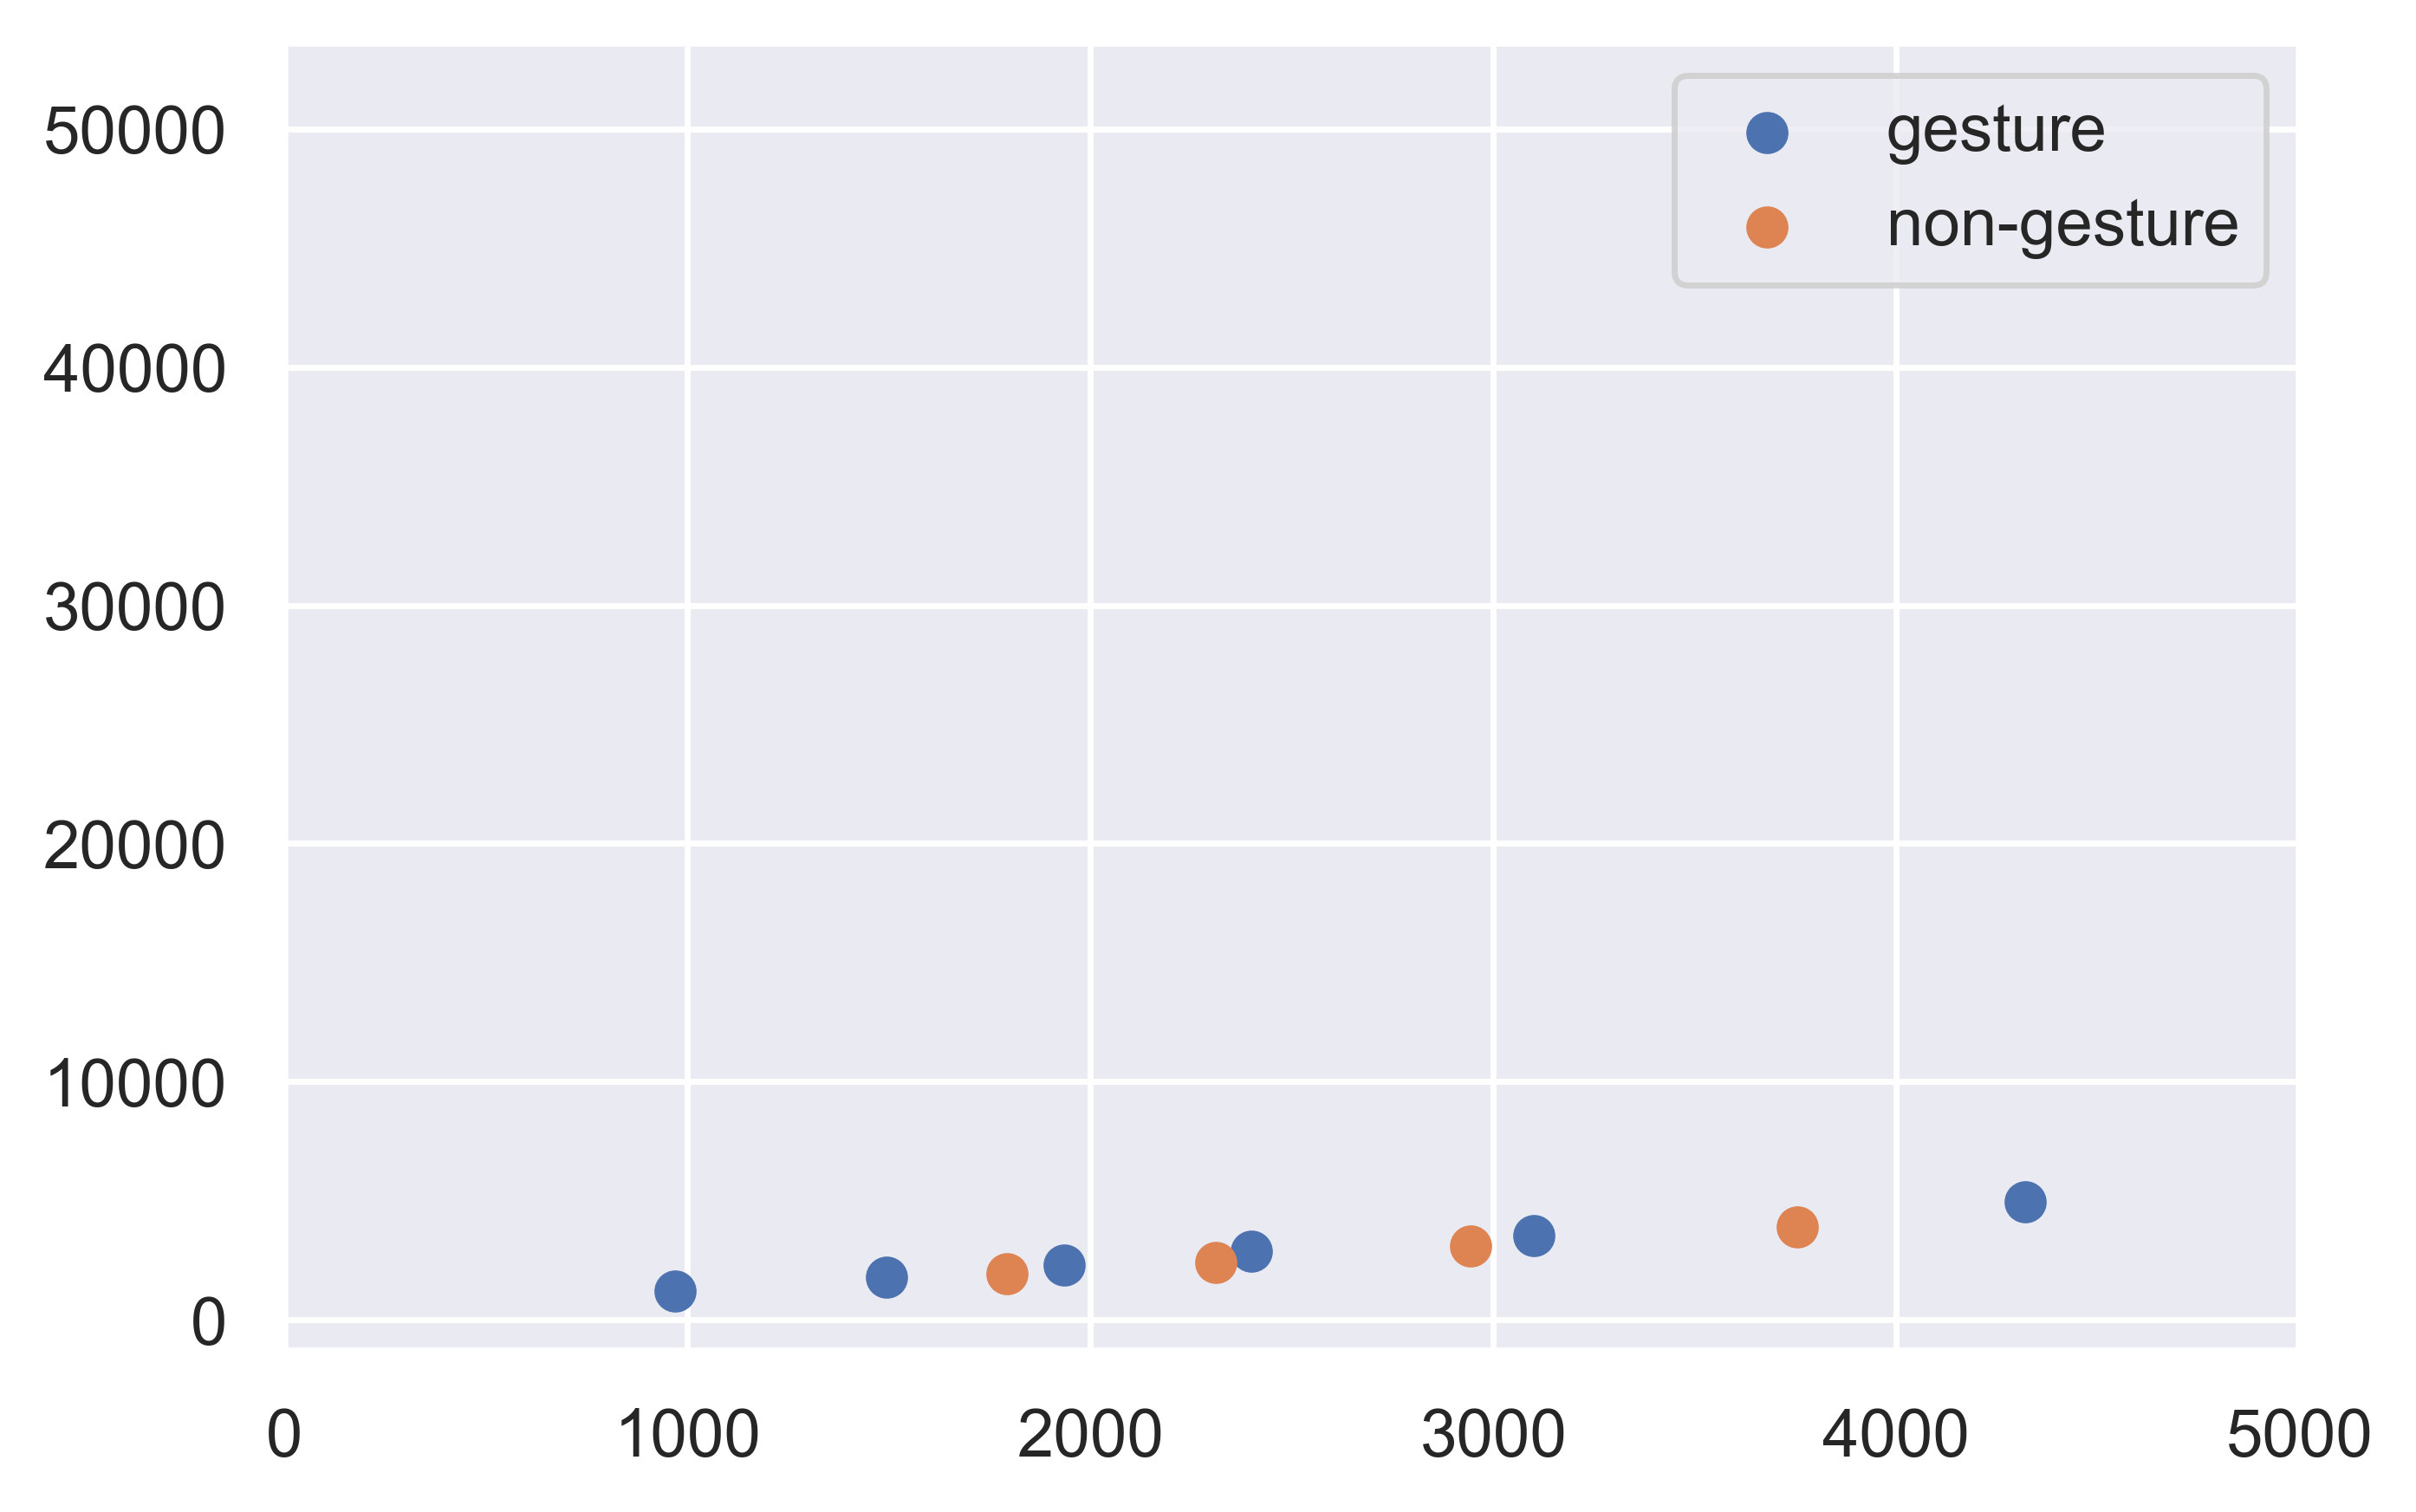

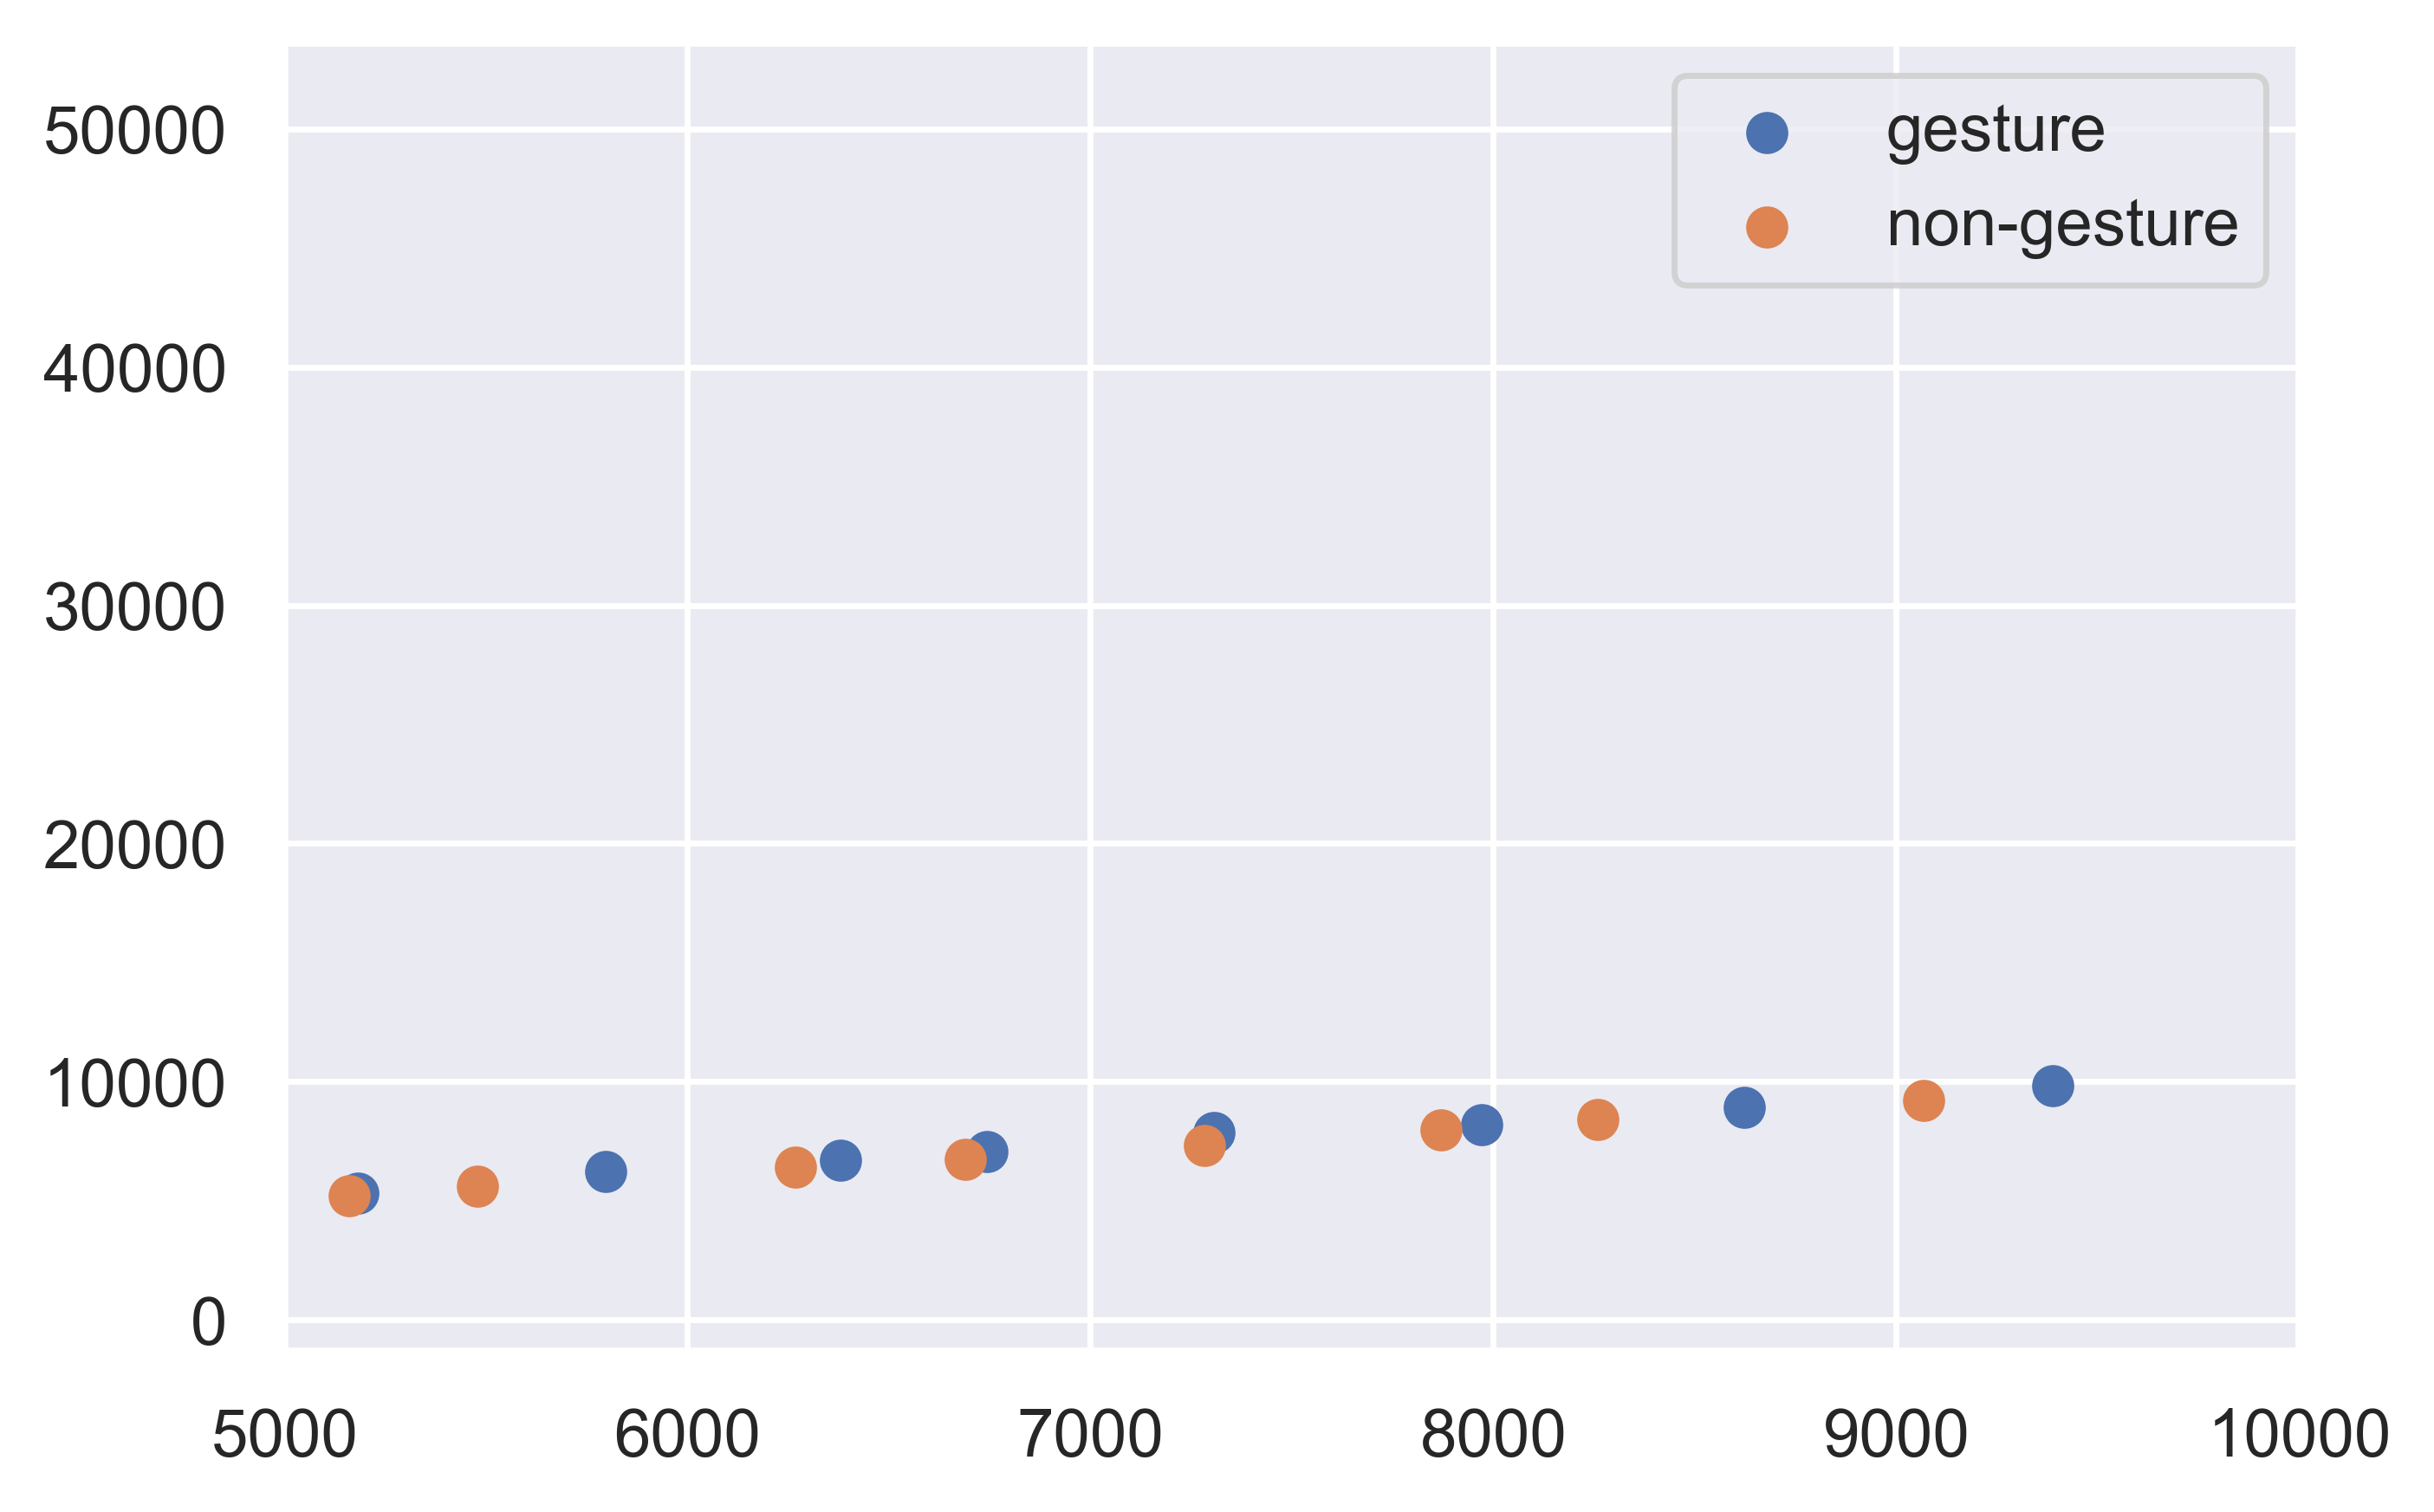

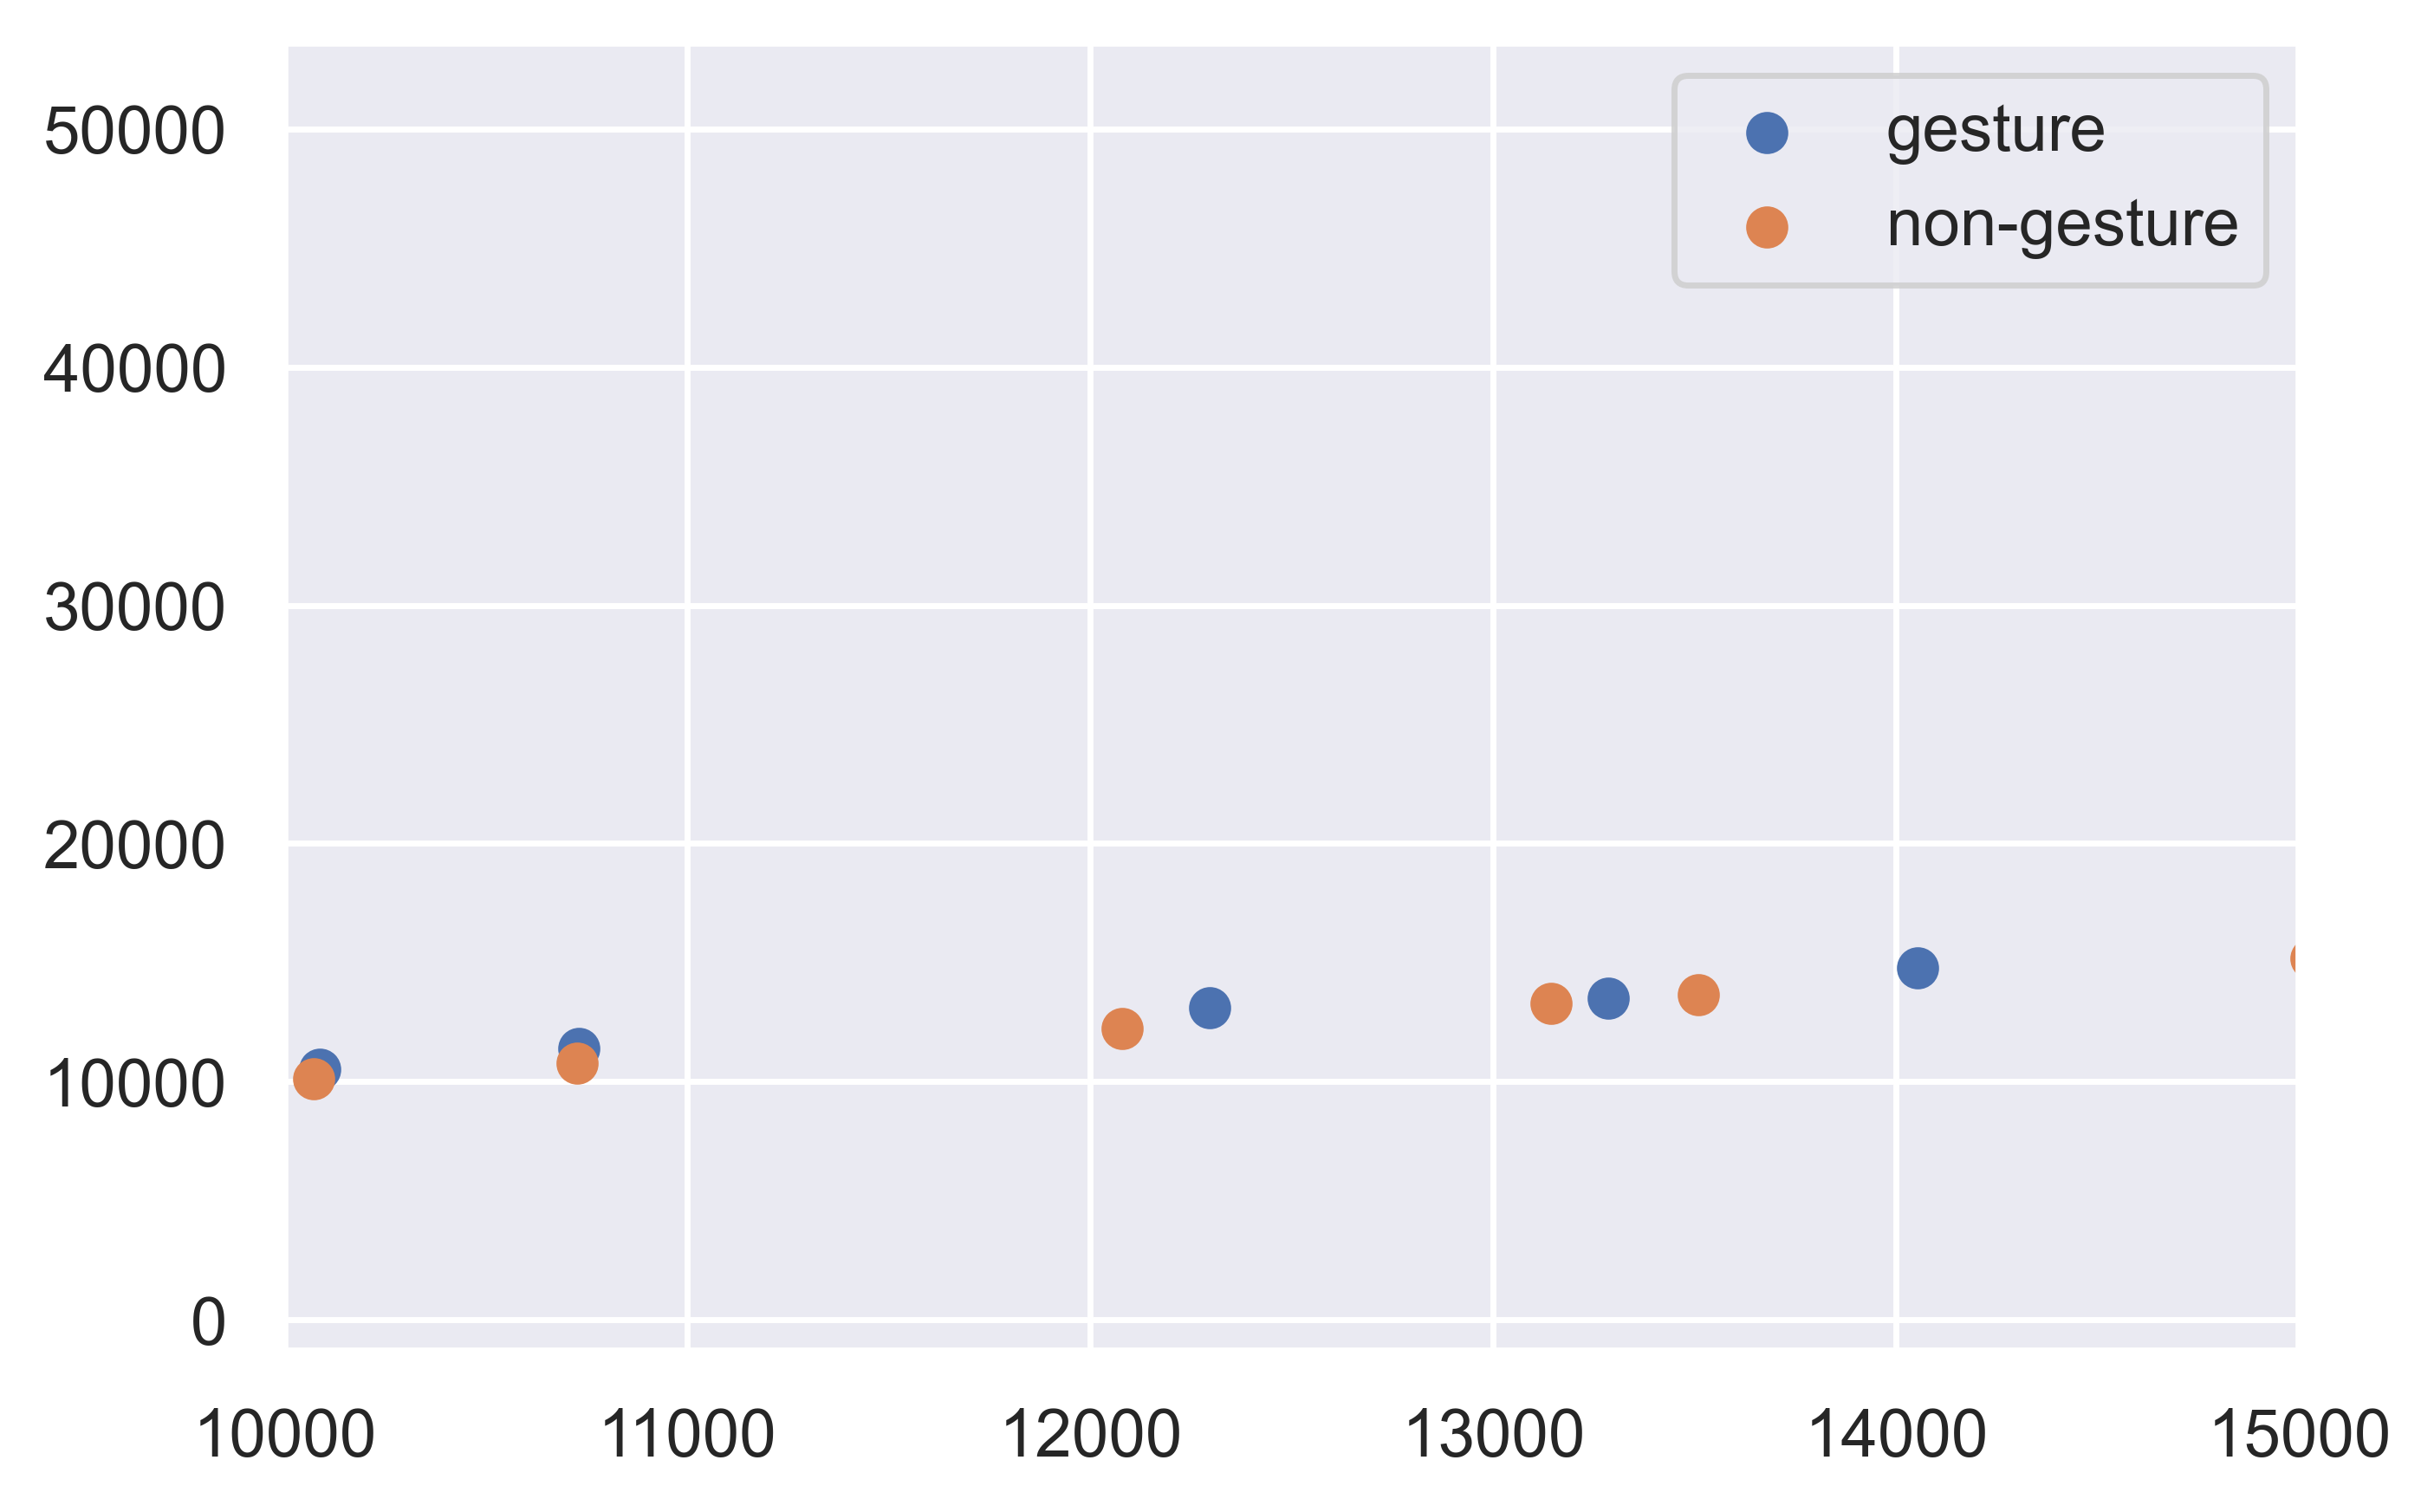

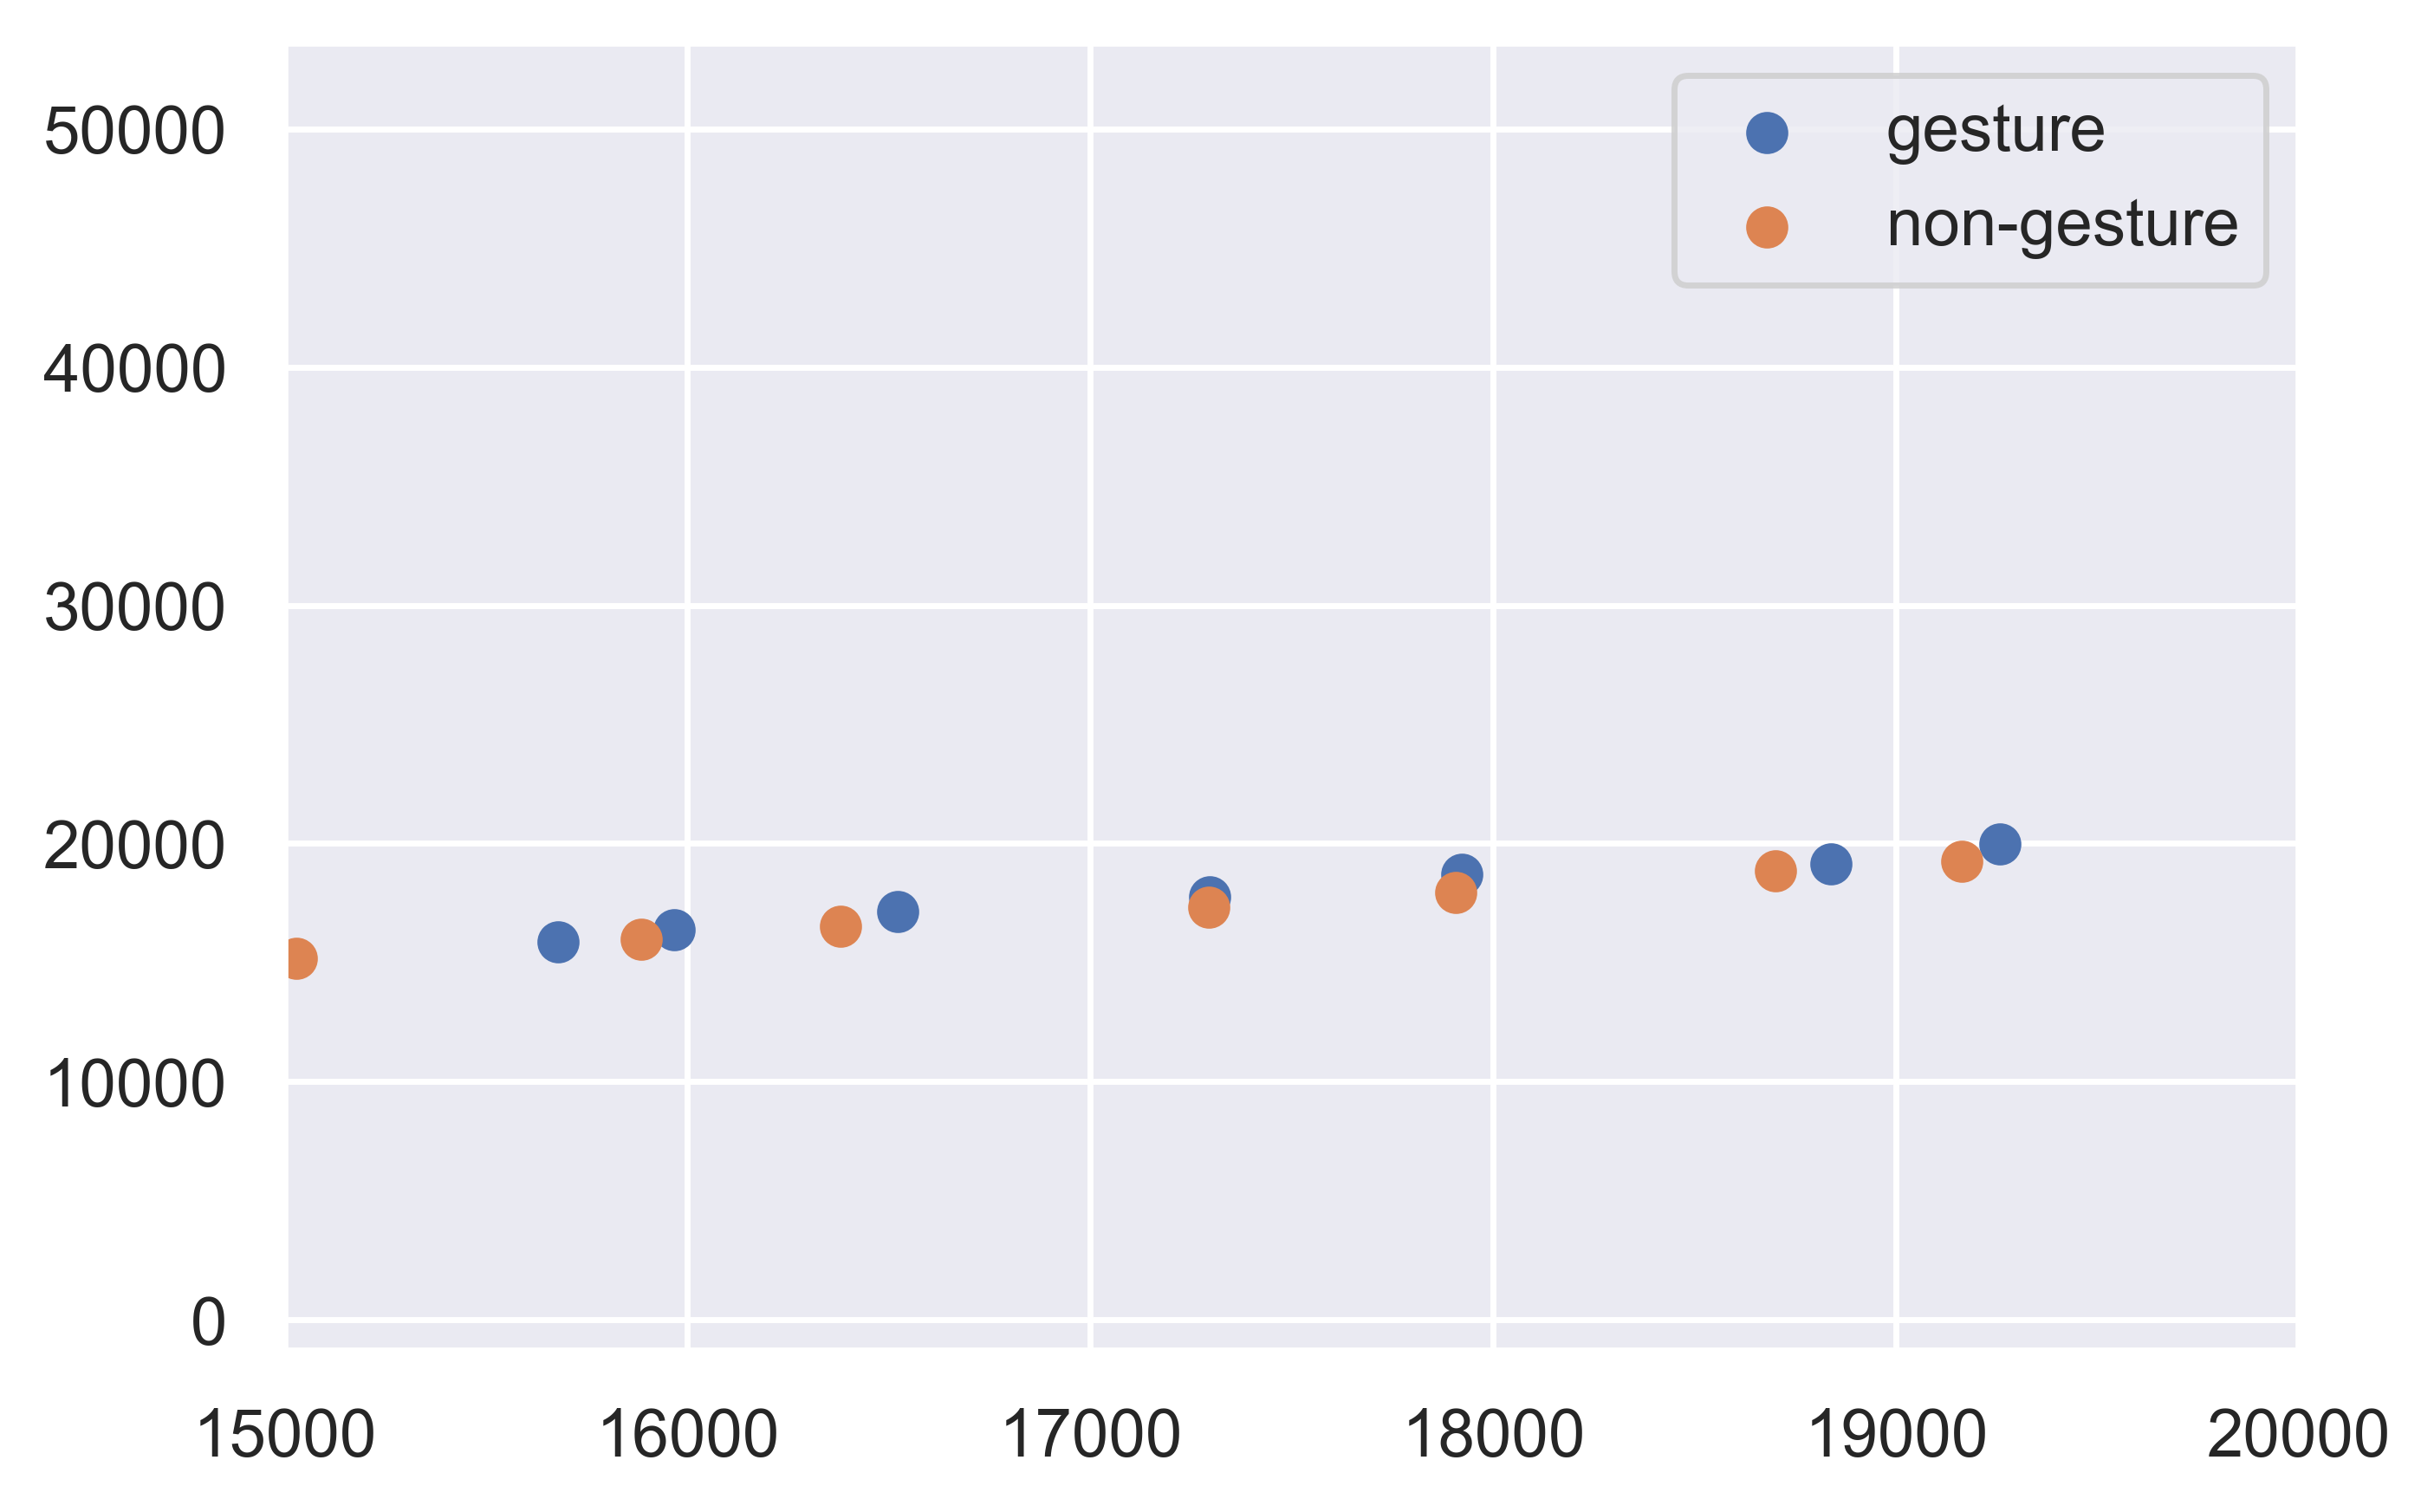

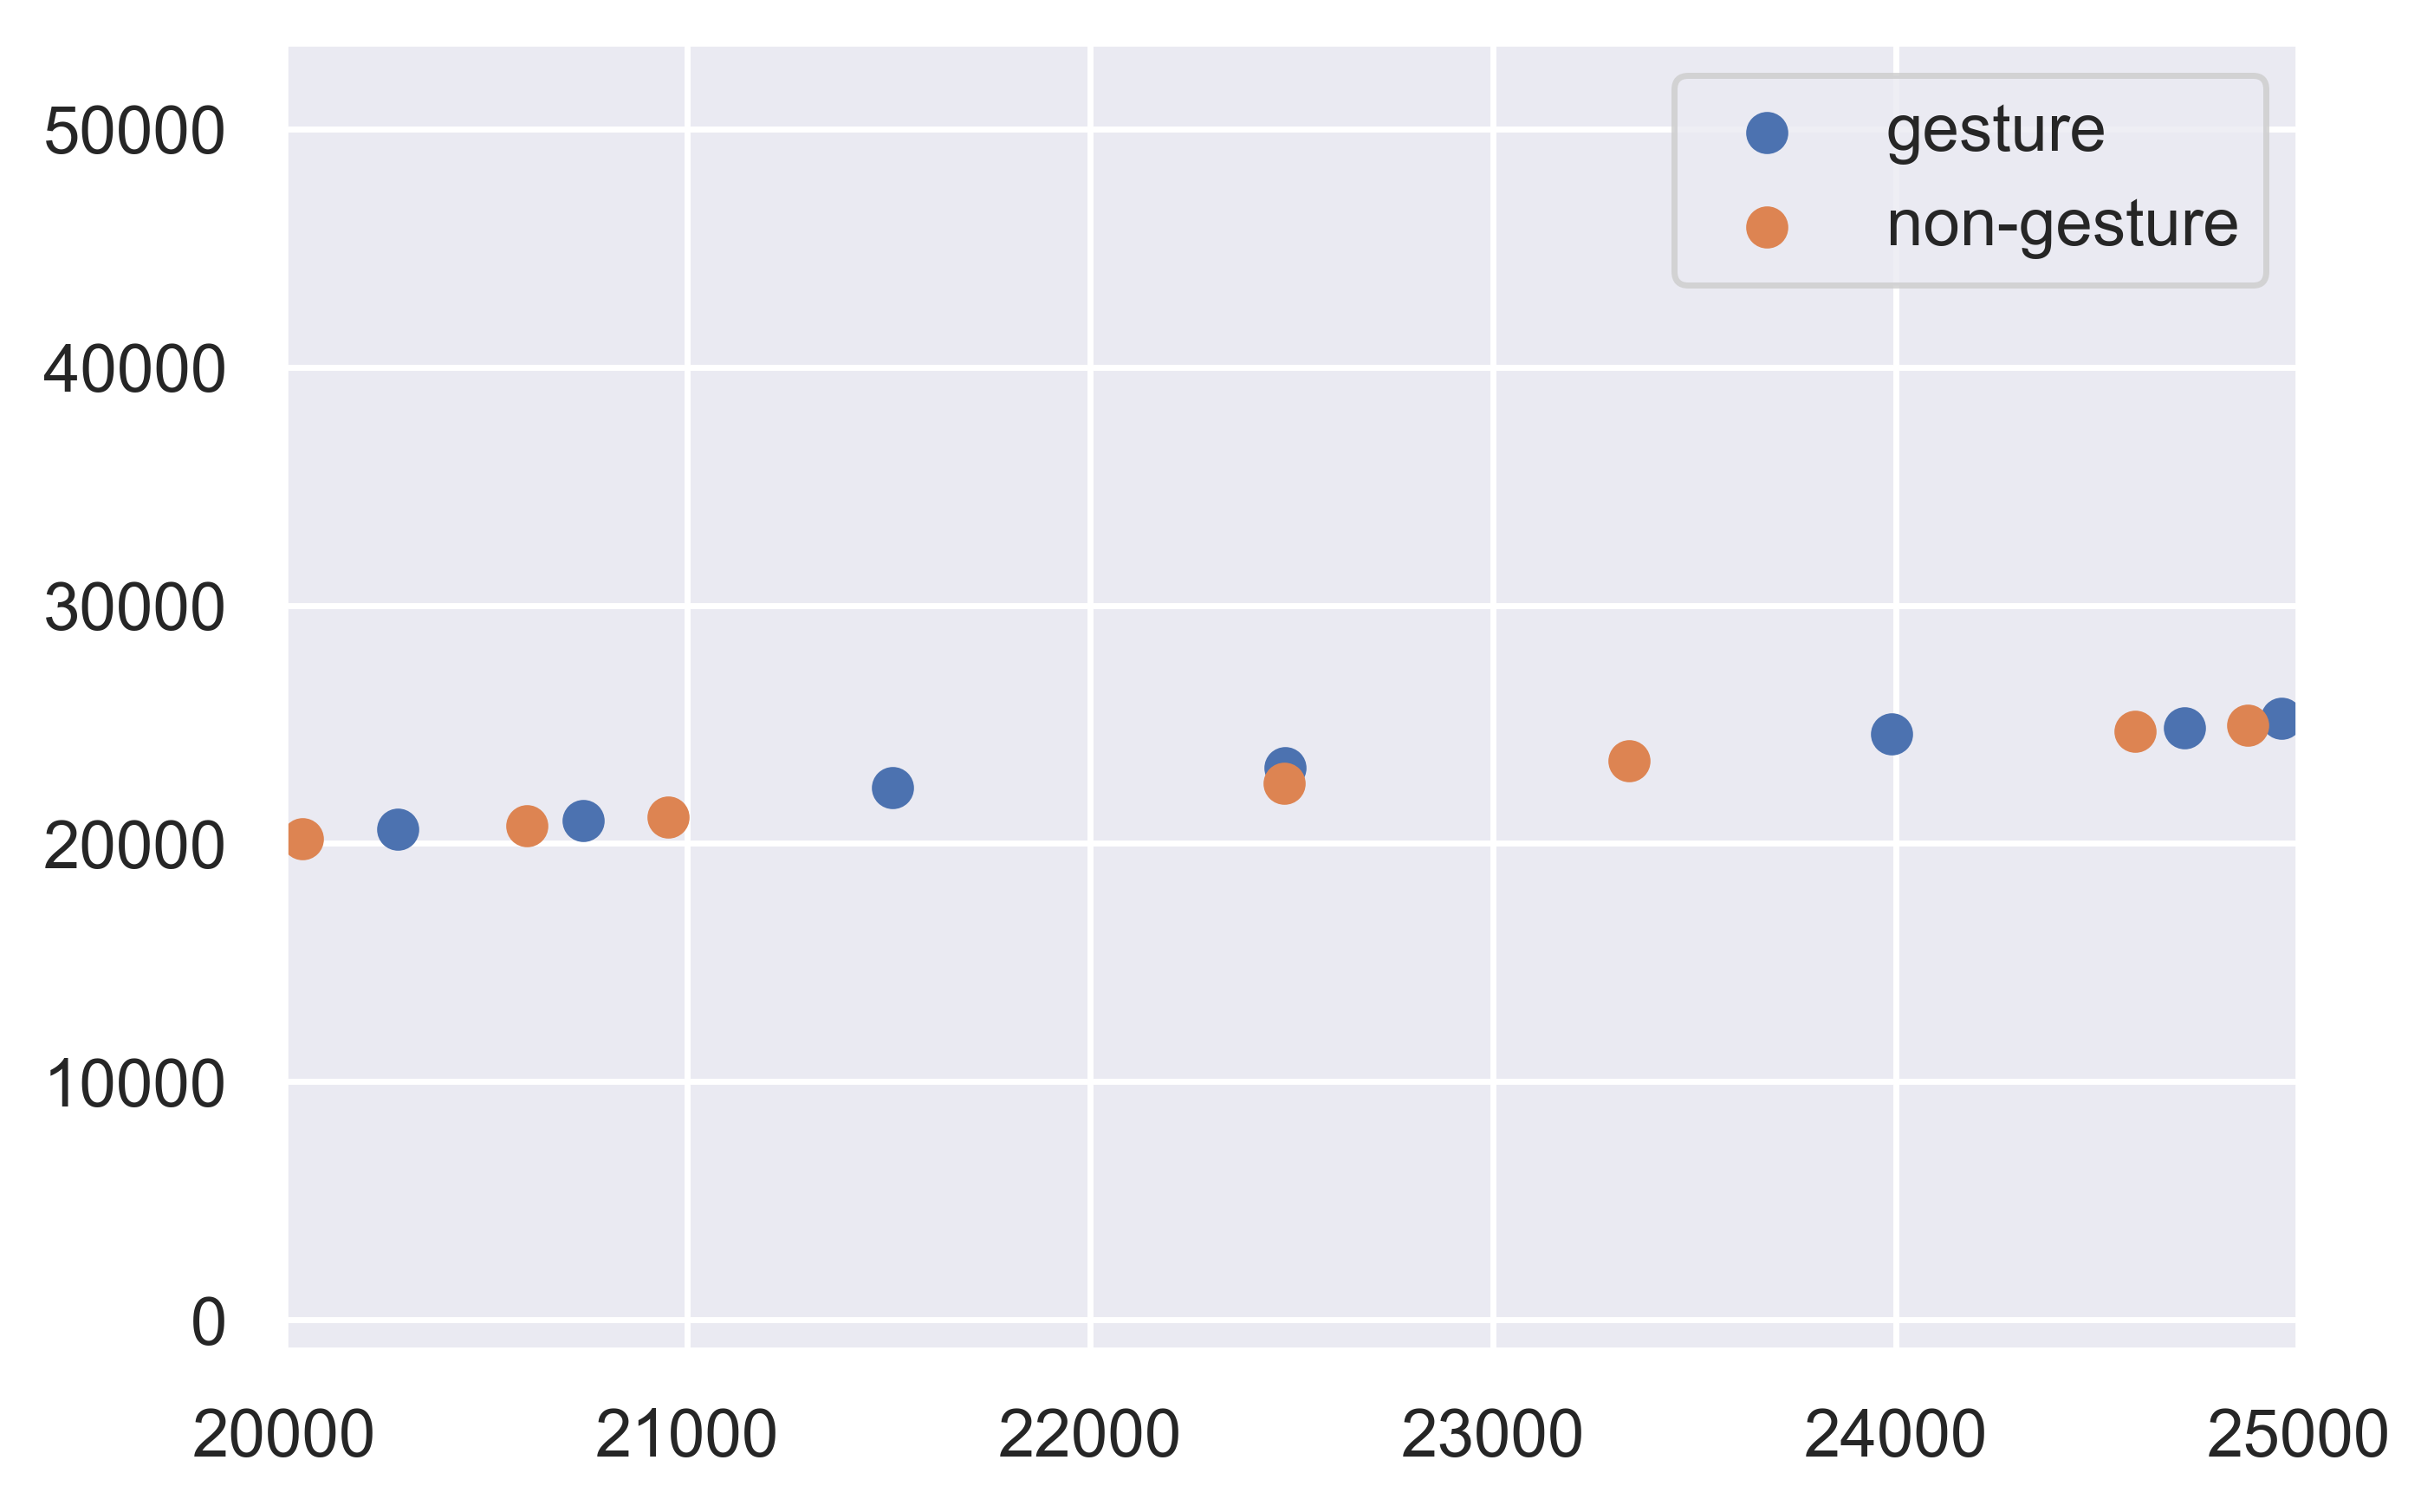

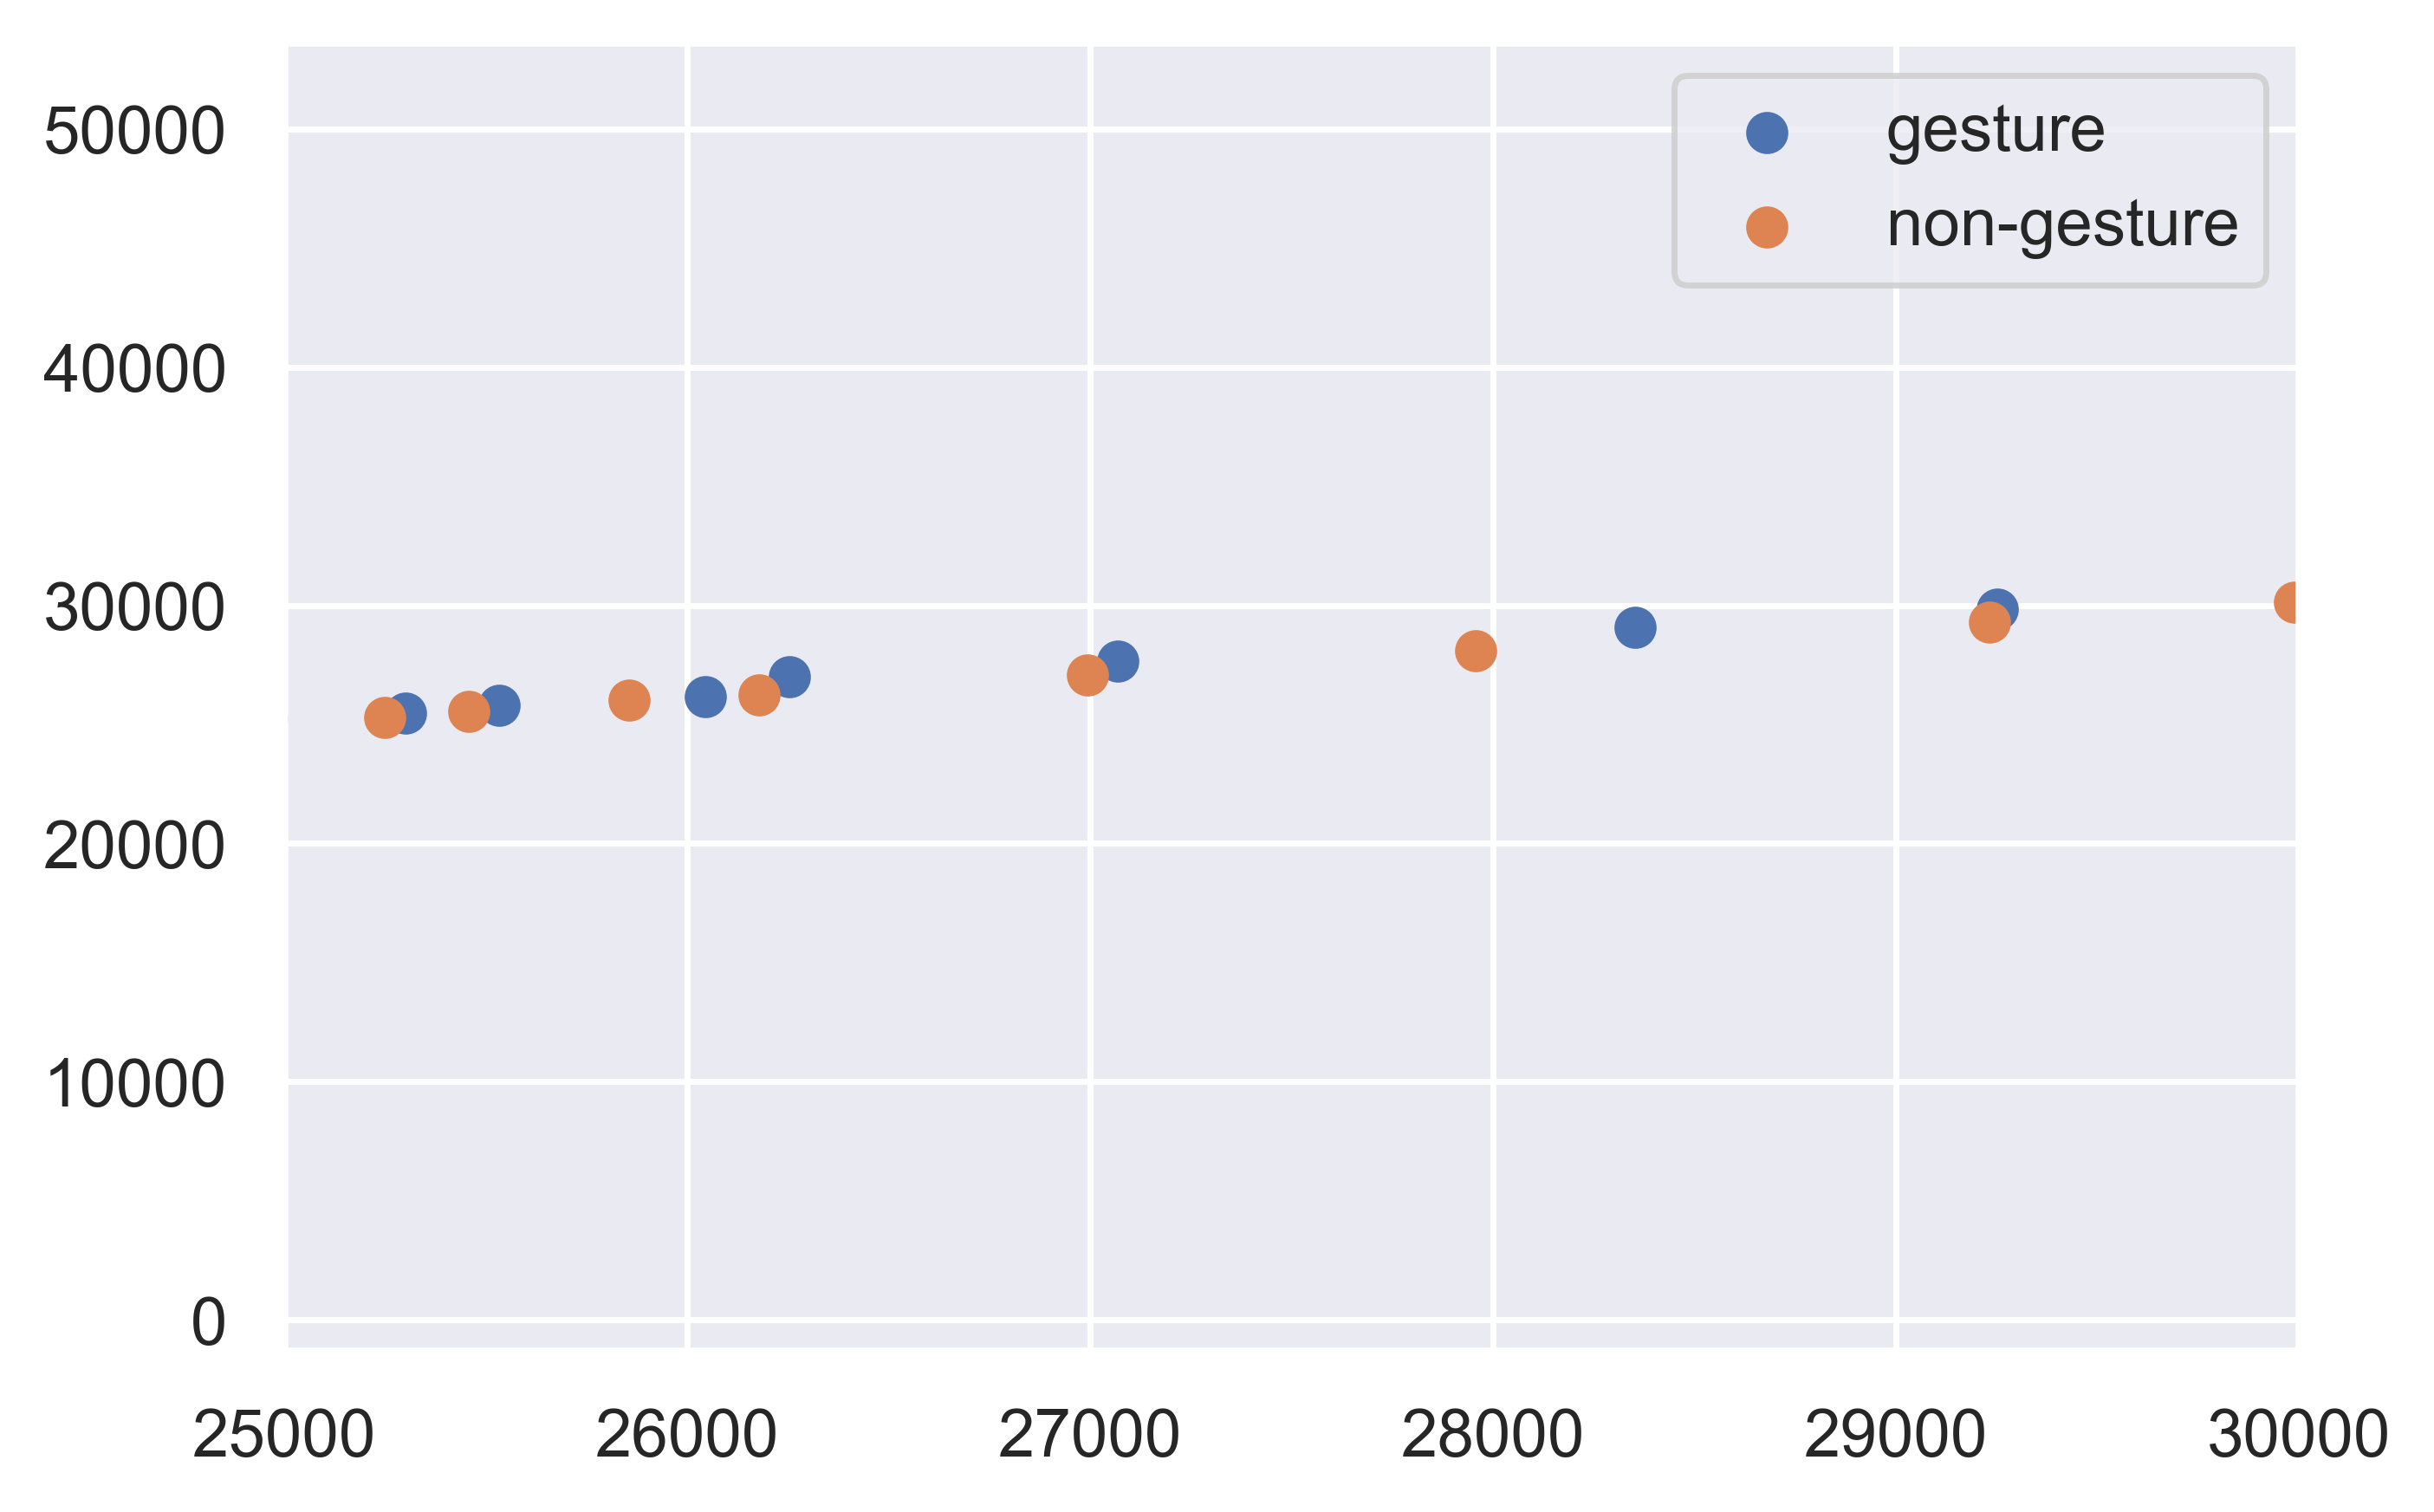

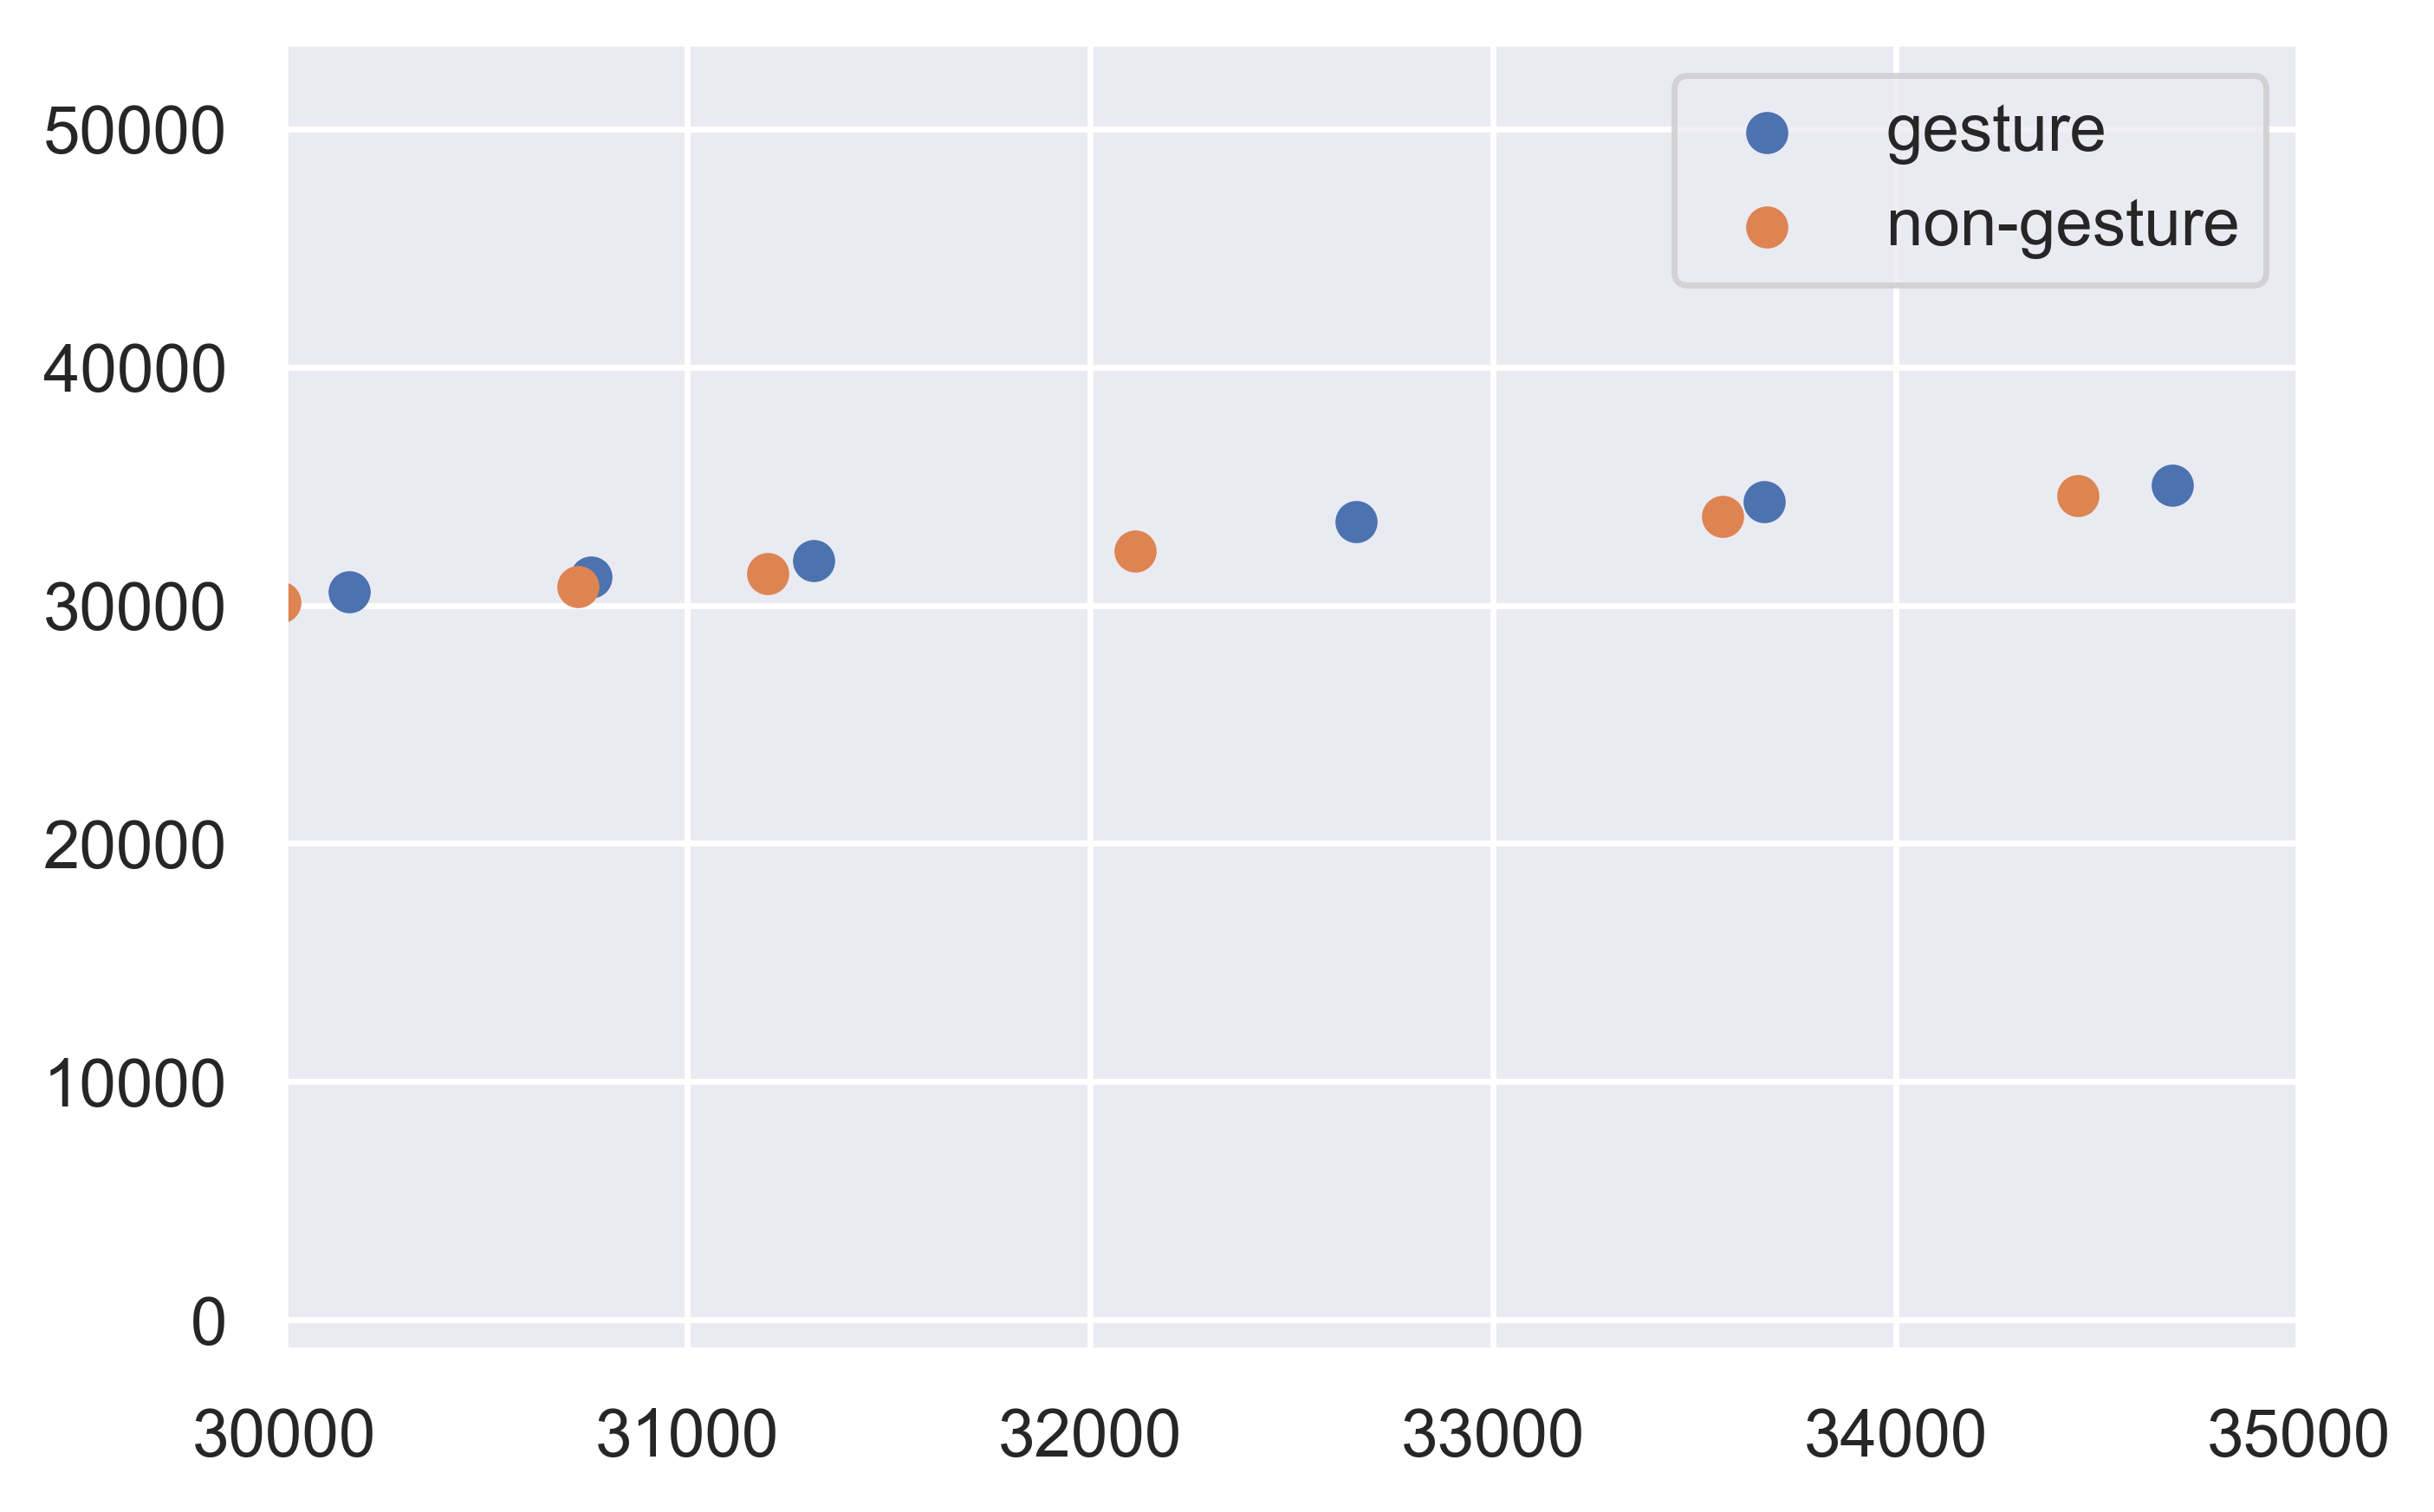

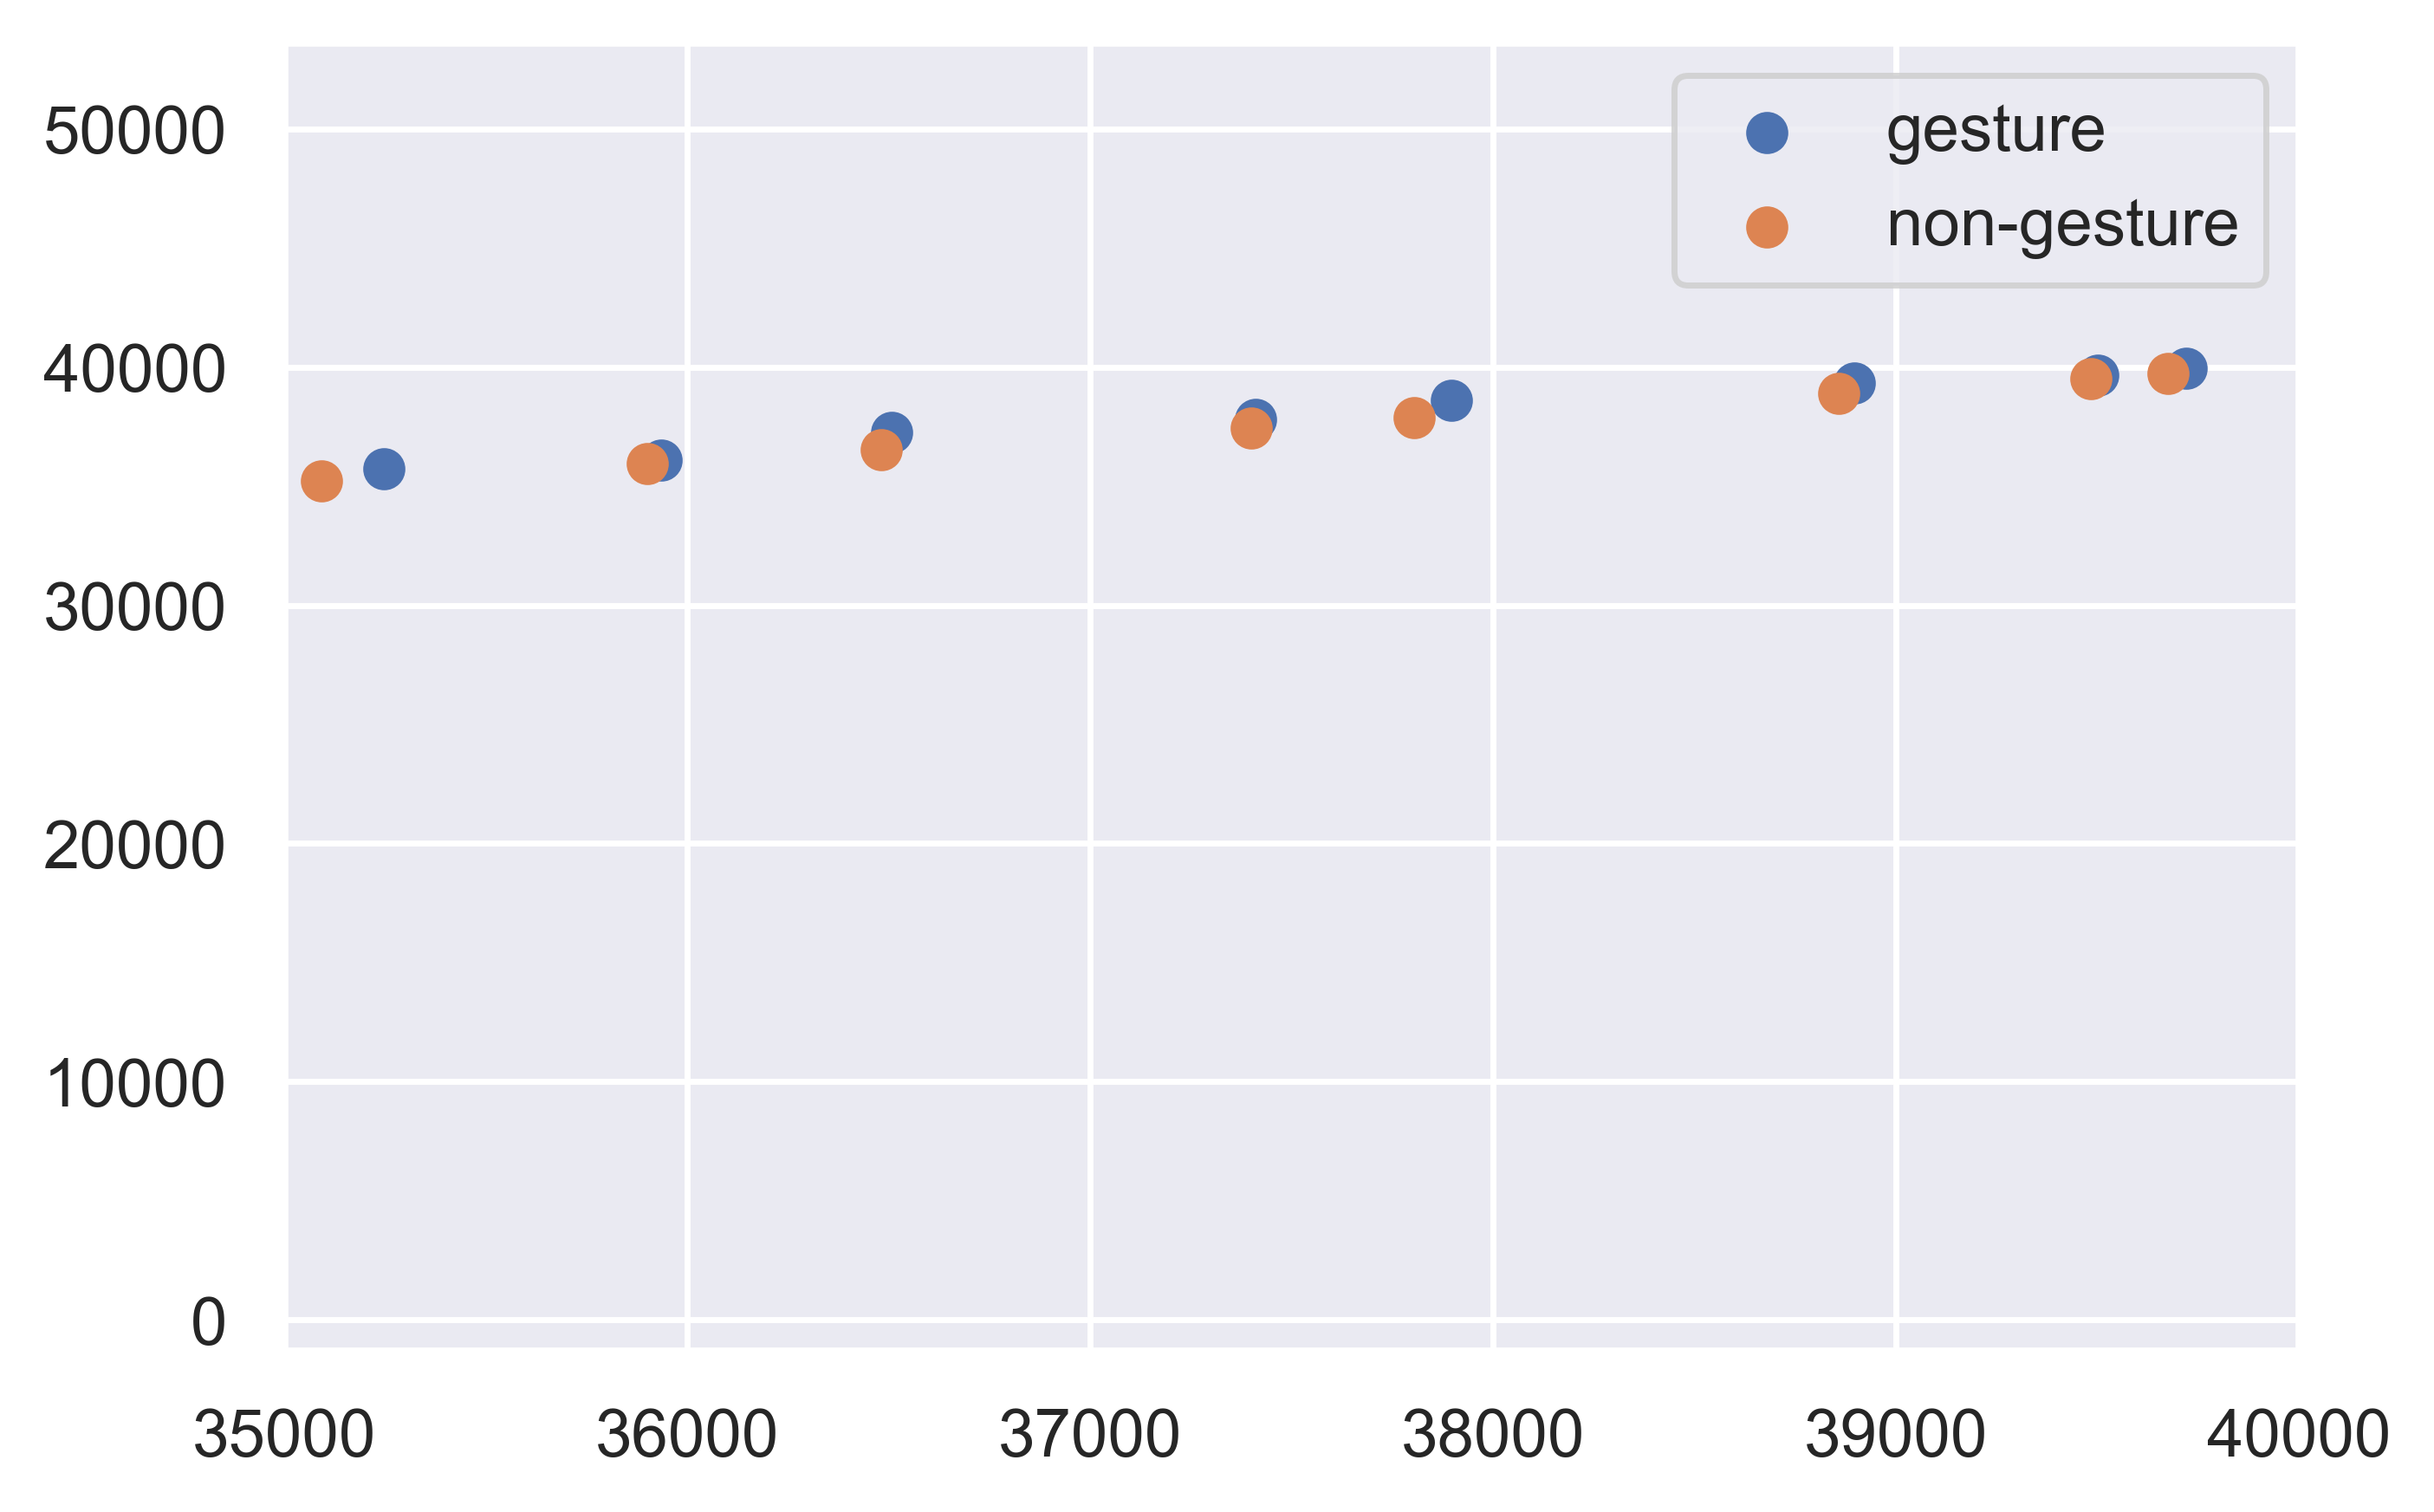

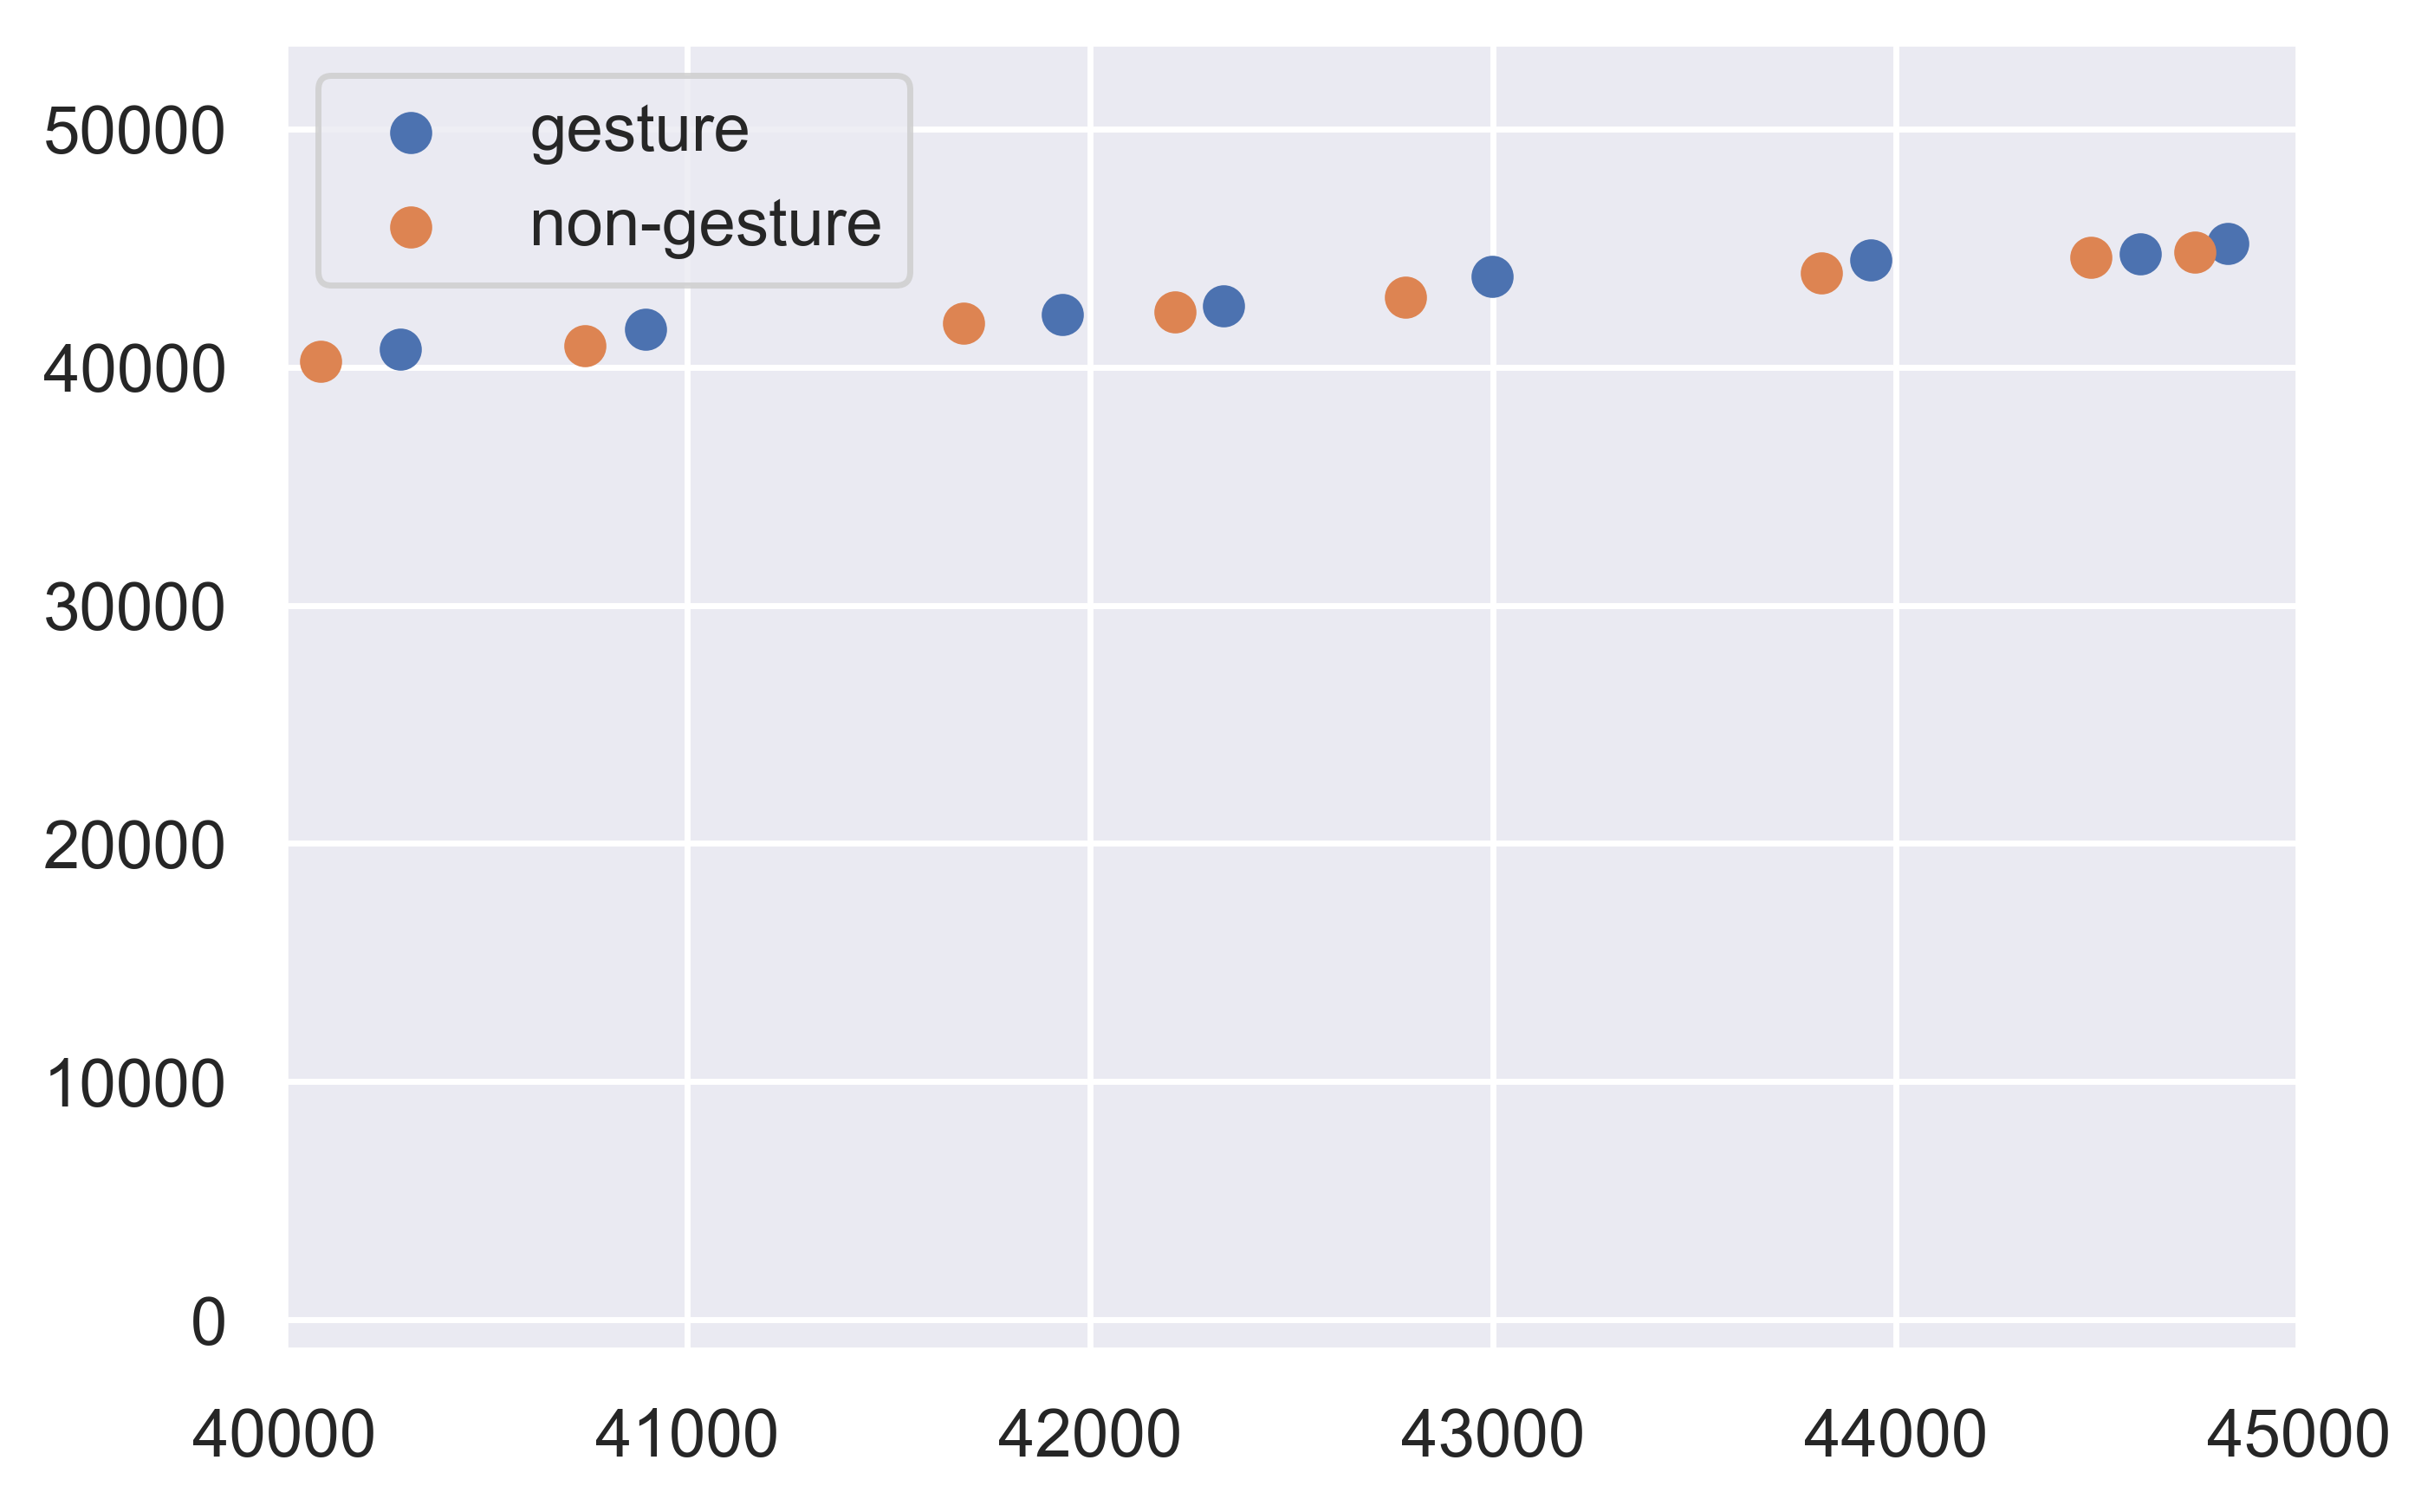

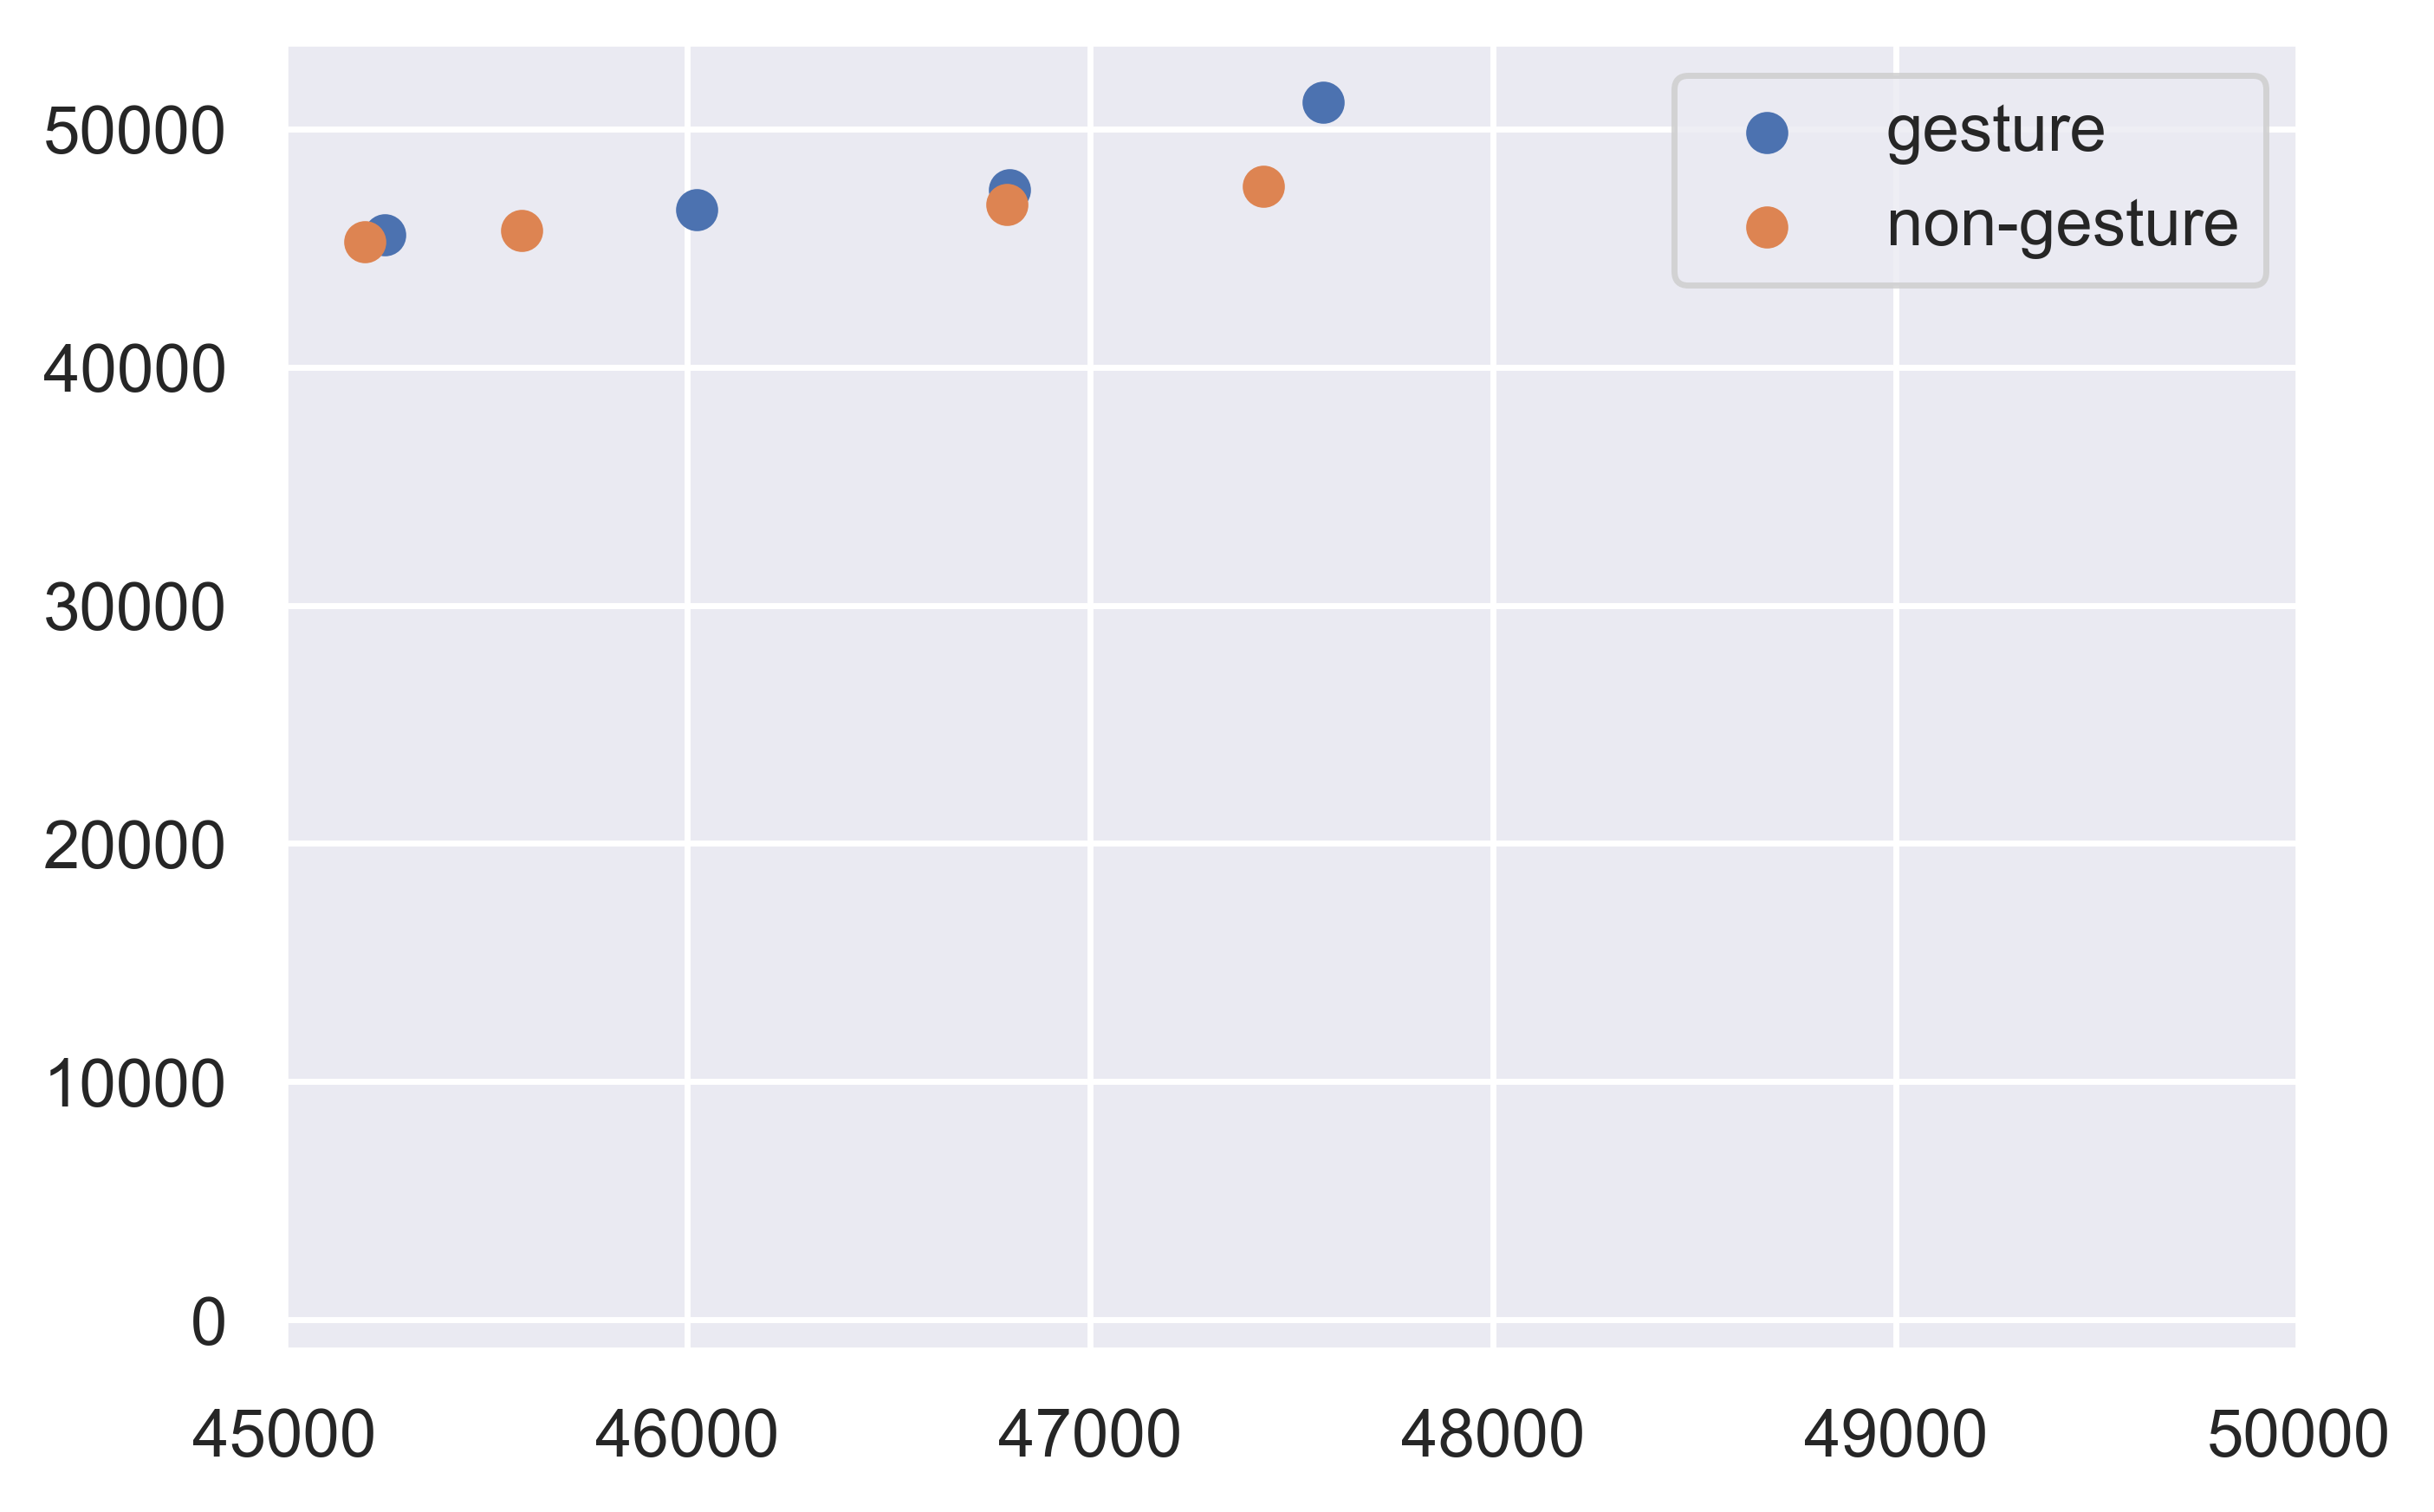

In [1289]:

for k in range(0,50000,5000):
    sns.set()
    plt.figure(dpi=500)
    # plt.scatter(transition_label[:,0],transition_label[:,1])
    plt.scatter(action_label_4[:,0],action_label_4[:,1])
    plt.scatter(non_gesture_label_3[:,0],non_gesture_label_3[:,1])
    plt.legend(('gesture','non-gesture'))
    plt.xlim((k,k+5000))
    #plt.savefig('%dver4.png'%k)